In [156]:
#!/usr/bin/env python
# coding=utf-8

# Detects and creates the collaboration graph based on the clustering results
# Evaluates content creator assignments, collaborations between channel, networks, categories and popularities

import pandas as pa 
import numpy as np

import json
import os
import networkx as nx
import pygraphviz as gz
from networkx.drawing.nx_pydot import write_dot
import math

from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

import itertools

import csv
from sqlalchemy import exists, func

from database import *

from matplotlib import pylab, pyplot
from matplotlib import dates

import seaborn as sns
sns.set(color_codes=True)

from scipy import stats, integrate

from datetime import datetime, timedelta, date

date_format = '%Y-%m-%dT%H:%M:%S.%fZ'
date_format2 = '%Y-%m-%d %H:%M:%S'

plt.style.use(['seaborn-paper'])
sns.set_style("whitegrid")
#plt.rc('font', family='serif', serif='Charter')
plt.rc('font', family='serif', serif='DejaVu Serif')

SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 13

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

x_width  = 6.8898
x_height = x_width / 1.618

s_width  = 3.4449
s_height = s_width / 1.618

def save_plot(name, fig, width, height):
    fig.tight_layout()
    fig.set_size_inches(width, height)
    #f.subplots_adjust(top=0.86)

    fig.savefig(CDIR+'/'+name, bbox_inches="tight")
    #plt.savefig(CDIR+'/video_view_percentages.pdf', bbox_inches="tight")

In [157]:
DIR = '../../data/data_evaluation_3MONTHS_filtered'
CDIR = '../../data/data_evaluation_3MONTHS_filtered/charts'

db = YTDatabase()

In [3]:
df_channel = pa.read_csv(DIR+r'/df_channel_statistics_first_day.txt', sep=str('\t'), encoding='utf-8')


In [4]:
df_channel= df_channel.set_index(['id'])

df_channel.loc[df_channel['network'] == 'Maker_Studios', 'network'] = 'Maker Studios'
#Fullscreen managed
df_channel.loc[df_channel['network'] == 'Fullscreen managed', 'network'] = 'Fullscreen'
df_channel.head()

,topicIds,network,viewCount,subscriberCount,videoCount,commentCount,category,popularity
id,,,,,,,,
UC__Pj66OeDibNZNN__L913g,Music,None,3253022,23029,967,0,Entertainment,2
UC__PZLSRGtUQiTtvm3hPoEQ,Movies,BroadbandTV,310896,5878,144,0,Entertainment,1
UC__rmdgxs3ZF0zK_he7Tmig,Lifestyle,None,1291254,8146,294,121,How-to & Style,1
UC_-CxgsxX0tpnm24WO-797Q,Lifestyle,Maker Studios,625545,18990,67,101,How-to & Style,2
UC_1FUFB6TlGeGOyDI4ikkzg,Movies,BroadbandTV,89020205,106760,288,0,Entertainment,3


In [5]:
# read collabs from database table
# session.query(VideoFaceCluster)
with db._session_scope(False) as session:

    df_feature_cluster = pa.read_sql(session.query(VideoFeatures.id, VideoFeatures.videoID, VideoFeatures.duration, Video.channelID, VideoFaceCluster.cluster).filter( (VideoFaceCluster.featureID == VideoFeatures.id) & (VideoFeatures.videoID == Video.id) ).statement, db.engine)

print df_feature_cluster.head()
print '\nnumber of feature', len(df_feature_cluster)
print 'number of channels:', df_feature_cluster['channelID'].nunique()
print 'number of videos', df_feature_cluster['videoID'].nunique()
print 'number of clusters:', df_feature_cluster['cluster'].nunique()

       id      videoID  duration                 channelID  cluster
0  159389  gjce2lOMhXs   2223.10  UC--BMyA2X4a9PGAo3lTuopg     9510
1  159391  gjce2lOMhXs   1633.47  UC--BMyA2X4a9PGAo3lTuopg     9510
2  159392  gjce2lOMhXs   1643.81  UC--BMyA2X4a9PGAo3lTuopg     9510
3  159395  gjce2lOMhXs   1350.18  UC--BMyA2X4a9PGAo3lTuopg    12551
4  159396  gjce2lOMhXs   1128.79  UC--BMyA2X4a9PGAo3lTuopg    12551

number of feature 145404
number of channels: 3740
number of videos 80491
number of clusters: 14010


In [15]:
# create df_feature_cluster with react videos filtered

# sql like 'react', reaction?

# read collabs from database table
# session.query(VideoFaceCluster)
with db._session_scope(False) as session:

    df_filtered_cluster = pa.read_sql(session.query(VideoFeatures.id, VideoFeatures.videoID, VideoFeatures.duration, Video.channelID, VideoFaceCluster.cluster).filter( (VideoFaceCluster.featureID == VideoFeatures.id) & (VideoFeatures.videoID == Video.id) & (~Video.title.like(u'%react%')) & (Video.category!=20) ).statement, db.engine)

print df_filtered_cluster.head()
print '\nnumber of feature', len(df_filtered_cluster)
print 'number of channels:', df_filtered_cluster['channelID'].nunique()
print 'number of videos', df_filtered_cluster['videoID'].nunique()
print 'number of clusters:', df_filtered_cluster['cluster'].nunique()

       id      videoID  duration                 channelID  cluster
0  159389  gjce2lOMhXs   2223.10  UC--BMyA2X4a9PGAo3lTuopg     9510
1  159391  gjce2lOMhXs   1633.47  UC--BMyA2X4a9PGAo3lTuopg     9510
2  159392  gjce2lOMhXs   1643.81  UC--BMyA2X4a9PGAo3lTuopg     9510
3  159395  gjce2lOMhXs   1350.18  UC--BMyA2X4a9PGAo3lTuopg    12551
4  159396  gjce2lOMhXs   1128.79  UC--BMyA2X4a9PGAo3lTuopg    12551

number of feature 77268
number of channels: 2822
number of videos 45893
number of clusters: 8703


number of videos for channel: 57
cluster in >10% videos:
Series([], Name: cluster, dtype: float64)


<IPython.core.display.Javascript object>


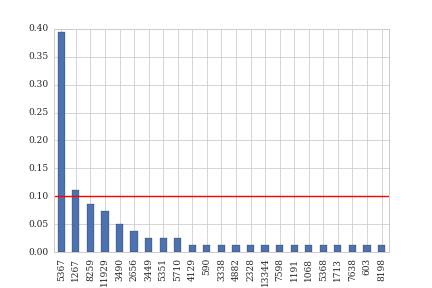

       relative_counts                 channelID
5367          0.395062  UC-lHJZR3Gqxm24_Vd_AJ5Yw
1267          0.111111  UC-lHJZR3Gqxm24_Vd_AJ5Yw
8259          0.086420  UC-lHJZR3Gqxm24_Vd_AJ5Yw
11929         0.074074  UC-lHJZR3Gqxm24_Vd_AJ5Yw
3490          0.049383  UC-lHJZR3Gqxm24_Vd_AJ5Yw
2656          0.037037  UC-lHJZR3Gqxm24_Vd_AJ5Yw
3449          0.024691  UC-lHJZR3Gqxm24_Vd_AJ5Yw
5351          0.024691  UC-lHJZR3Gqxm24_Vd_AJ5Yw
5710          0.024691  UC-lHJZR3Gqxm24_Vd_AJ5Yw
4129          0.012346  UC-lHJZR3Gqxm24_Vd_AJ5Yw
590           0.012346  UC-lHJZR3Gqxm24_Vd_AJ5Yw
3338          0.012346  UC-lHJZR3Gqxm24_Vd_AJ5Yw
4882          0.012346  UC-lHJZR3Gqxm24_Vd_AJ5Yw
2328          0.012346  UC-lHJZR3Gqxm24_Vd_AJ5Yw
13344         0.012346  UC-lHJZR3Gqxm24_Vd_AJ5Yw
7598          0.012346  UC-lHJZR3Gqxm24_Vd_AJ5Yw
1191          0.012346  UC-lHJZR3Gqxm24_Vd_AJ5Yw
1068          0.012346  UC-lHJZR3Gqxm24_Vd_AJ5Yw
5368          0.012346  UC-lHJZR3Gqxm24_Vd_AJ5Yw
1713          0.0123

<IPython.core.display.Javascript object>


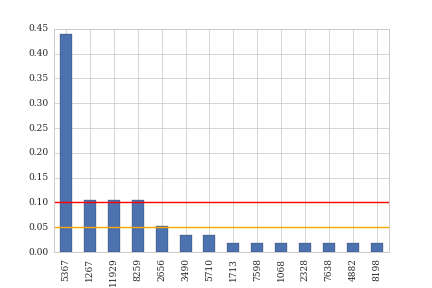

       relative_counts                 channelID
5367          0.438596  UC-lHJZR3Gqxm24_Vd_AJ5Yw
1267          0.105263  UC-lHJZR3Gqxm24_Vd_AJ5Yw
11929         0.105263  UC-lHJZR3Gqxm24_Vd_AJ5Yw
8259          0.105263  UC-lHJZR3Gqxm24_Vd_AJ5Yw
2656          0.052632  UC-lHJZR3Gqxm24_Vd_AJ5Yw
3490          0.035088  UC-lHJZR3Gqxm24_Vd_AJ5Yw
5710          0.035088  UC-lHJZR3Gqxm24_Vd_AJ5Yw
1713          0.017544  UC-lHJZR3Gqxm24_Vd_AJ5Yw
7598          0.017544  UC-lHJZR3Gqxm24_Vd_AJ5Yw
1068          0.017544  UC-lHJZR3Gqxm24_Vd_AJ5Yw
2328          0.017544  UC-lHJZR3Gqxm24_Vd_AJ5Yw
7638          0.017544  UC-lHJZR3Gqxm24_Vd_AJ5Yw
4882          0.017544  UC-lHJZR3Gqxm24_Vd_AJ5Yw
8198          0.017544  UC-lHJZR3Gqxm24_Vd_AJ5Yw


In [16]:
# testing filtering with 10% mark

from sklearn.preprocessing import normalize

channel_groups = df_feature_cluster.groupby('channelID')
filtered_channel_groups = df_filtered_cluster.groupby('channelID')

df_test = pa.DataFrame()
df_test_filtered = pa.DataFrame()

print 'number of videos for channel:', df_feature_cluster[df_feature_cluster.channelID == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']['videoID'].nunique()
f = df_feature_cluster[df_feature_cluster.channelID == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']['videoID'].nunique() * 0.1
counts = channel_groups.get_group('UC-lHJZR3Gqxm24_Vd_AJ5Yw')['cluster'].value_counts(normalize=True)
df_test['relative_counts'] = counts
df_test['channelID'] = 'UC-lHJZR3Gqxm24_Vd_AJ5Yw'
print 'cluster in >10% videos:\n', counts[counts >= f]
fig = plt.figure()
ax = counts.plot(kind='bar')
ax.axhline(0.1, color='red')
print df_test

print 'number of videos for channel, filtered:', df_filtered_cluster[df_filtered_cluster.channelID == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']['videoID'].nunique()
f = df_filtered_cluster[df_filtered_cluster.channelID == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']['videoID'].nunique() * 0.1
counts = filtered_channel_groups.get_group('UC-lHJZR3Gqxm24_Vd_AJ5Yw')['cluster'].value_counts(normalize=True)
df_test_filtered['relative_counts'] = counts
df_test_filtered['channelID'] = 'UC-lHJZR3Gqxm24_Vd_AJ5Yw'
print 'cluster in >10% videos, filtered:\n', counts[counts >= f]
fig = plt.figure()
ax = counts.plot(kind='bar')
ax.axhline(0.1, color='red')
ax.axhline(0.05, color='orange')
print df_test_filtered


In [17]:
# create table with relative cluster counts per channel, plot dist

df_relative_counts = pa.DataFrame()
df_number_videos = []

for name, group in filtered_channel_groups:
    
    df_test = pa.DataFrame()

    df_number_videos.append(df_filtered_cluster[df_filtered_cluster.channelID == name]['videoID'].nunique())
    counts = group['cluster'].value_counts(normalize=True)
    df_test['relative_counts'] = counts
    df_test['channelID'] = name
    df_relative_counts = df_relative_counts.append(df_test)

df_number_videos = pa.DataFrame(df_number_videos)
df_relative_counts.head()

,relative_counts,channelID
9511,0.36,UC--BMyA2X4a9PGAo3lTuopg
9512,0.24,UC--BMyA2X4a9PGAo3lTuopg
12552,0.16,UC--BMyA2X4a9PGAo3lTuopg
12551,0.12,UC--BMyA2X4a9PGAo3lTuopg
9510,0.12,UC--BMyA2X4a9PGAo3lTuopg


<IPython.core.display.Javascript object>


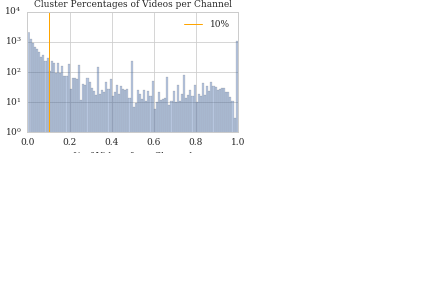

<IPython.core.display.Javascript object>


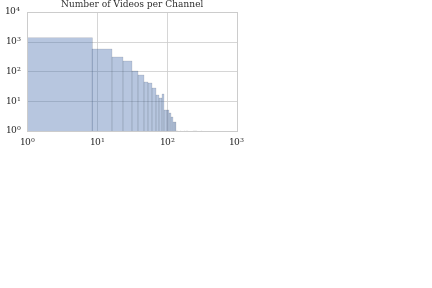

In [18]:
fig = plt.figure()
ax = sns.distplot(df_relative_counts['relative_counts'], kde=False, bins=100)
#ax.axvline(0.25, color='yellow', label='25%', linewidth=0.5)
ax.axvline(0.1, color='orange', label='10%', linewidth=1.0)
#ax.axvline(0.05, color='red', label='5%', linewidth=0.8)
ax.set_xlabel('% of Videos from Channel')
ax.set_ylabel('Cluster')
#ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.title('Cluster Percentages of Videos per Channel')

save_plot('channel_video_cluster_percentages.pdf', fig, s_width, s_height)

fig = plt.figure()
ax = sns.distplot(df_number_videos, kde=False)
ax.set_xlabel('Number of Videos')
ax.set_ylabel('Channel')
ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Number of Videos per Channel')


save_plot('channel_nof_videos.pdf', fig, s_width, s_height)

In [21]:
'''
cluster = {}

label = df_feature_cluster['cluster'].unique()

for l in label:
    ftl = df_feature_cluster[df_feature_cluster.cluster == l]
    groups = ftl.groupby(['channelID'])
    vcounts = groups.videoID.nunique()
    vtcounts = groups.videoID.unique()
    vcounts = vcounts.sort_values(ascending=False)
    vs = vcounts.index
    vtcounts = vtcounts.reindex(vs)
    # TODO get average(?) duration for collabs too
    cluster[l] = [(cid, nof, list(vids)) for (cid, nof), (cid2, vids) in zip(vcounts.iteritems(), vtcounts.iteritems())]
    #print l, cluster[l]
    #print vtcounts
'''
    
filtered_cluster = {}

label = df_filtered_cluster['cluster'].unique()

for l in label:
    ftl = df_filtered_cluster[df_filtered_cluster.cluster == l]
    groups = ftl.groupby(['channelID'])
    vcounts = groups.videoID.nunique()
    vtcounts = groups.videoID.unique()
    vcounts = vcounts.sort_values(ascending=False)
    vs = vcounts.index
    vtcounts = vtcounts.reindex(vs)
    # TODO get average(?) duration for collabs too
    filtered_cluster[l] = [(cid, nof, list(vids)) for (cid, nof), (cid2, vids) in zip(vcounts.iteritems(), vtcounts.iteritems())]
    #print l, filtered_cluster[l]
    #print vtcounts

    

In [26]:
print cluster[3]
print filtered_cluster[8]

[(u'UCIjquHL0-e5Z5YmmVOPIHpg', 2, [u'reojjQ6XsM8', u'vuSTBd6oLsQ']), (u'UC9RRAHA3RuA0N0Genbekgrg', 2, [u'MAnOFA2OqCw', u'pSr-upnC4t4'])]
[(u'UCpTgltu3Ap618ySFFdWaHjg', 1, [u'5tYdW3Aii7c'])]


In [27]:
# create graph from collabs table

def create_graph(df, cluster):

    G = nx.DiGraph() # directed graph


    for l, cls in cluster.iteritems():
        if cls[0][1] >= math.ceil(df[df.channelID == cls[0][0]]['videoID'].nunique() * 0.1):
            mainc = cls[0][0]
            if G.has_node(mainc):
                if 'cluster' in G.node[mainc]:
                    G.node[mainc]['cluster'].append(str(l))
                else:
                    G.node[mainc]['cluster'] = [str(l)]

                    with db._session_scope(False) as session:
                        G.node[mainc]['network'] = session.query(Channel.network).filter(Channel.id == mainc).first()[0]

            else:
                with db._session_scope(False) as session:
                    network = session.query(Channel.network).filter(Channel.id == mainc).first()[0]
                G.add_node(mainc, cluster=[str(l)], network=network)

            for (c, n, v) in cls[1:]:
                G.add_edge(mainc, c, weight=int(n), cluster=str(l), videos=v)


    print '\nNodes:',len(G.nodes())
    print 'Edges:',len(G.edges())

    print 'Collabs (weight sum)', G.size(weight='weight')

    for x in G.nodes():
        if not 'network' in G.node[x]:
            with db._session_scope(False) as session:
                    G.node[x]['network'] = session.query(Channel.network).filter(Channel.id == x).first()[0]
        if not 'cluster' in G.node[x]:
            G.node[x]['cluster'] = ''
        #print G.node[x]['network']
        
    return G

G = create_graph(df_feature_cluster, cluster)

Gf = create_graph(df_filtered_cluster, filtered_cluster)


nx.write_gml(G, DIR+"/collab_detections_graph.gml")
nx.write_gml(Gf, DIR+"/filtered_collab_detections_graph.gml")


Nodes: 3625
Edges: 3475
Collabs (weight sum) 7614.0

Nodes: 2775
Edges: 1728
Collabs (weight sum) 3925.0


In [189]:
df_collab_channels = pa.Series(Gf.nodes())

print len(df_collab_channels.unique())

df_collab_channels_deg = pa.Series(Gf.degree())

print df_collab_channels_deg.value_counts()


2775
0     1176
1      827
2      340
3      175
4      101
5       64
6       35
7       23
8       14
10       8
9        5
11       2
16       2
12       2
14       1
dtype: int64


In [ ]:
for c in nx.isolates(Gf):
    

In [15]:
#G = nx.read_gml(DIR+"/collab_detections_graph.gml")
#Gf = nx.read_gml(DIR+"/filtered_collab_detections_graph.gml")

In [28]:
# compare graphs


# first compare nodes, which are present, which missing
Gf_missing = set()
for node in G.nodes():
    if not Gf.has_node(node):
        Gf_missing.add(node)

Gf_adds = set()
for node in Gf.nodes():
    if not G.has_node(node):
        Gf_adds.add(node)
        
with db._session_scope(False) as session:
    df_missing = pa.read_sql(session.query(Channel.title).filter((Channel.id.in_(Gf_missing))).statement, db.engine)
    df_adds = pa.read_sql(session.query(Channel.title).filter((Channel.id.in_(Gf_adds))).statement, db.engine)

print 'Missing:\n', df_missing
print 'Added:\n', df_adds

# then add all for edge comparision
Gfc = Gf.copy()
Gfc.add_nodes_from(list(Gf_missing))
   
Gc = G.copy()
Gc.add_nodes_from(list(Gf_adds))

Gc_diff = nx.difference(Gc, Gfc)
print '\nMissing edges:', len(Gc_diff.edges())
weight_sum = 0
for e in Gc_diff.edges():
        weight_sum += Gc.get_edge_data(e[0], e[1])['weight'] 
print 'Missing collabs:', weight_sum

Gfc_diff = nx.difference(Gfc, Gc)
print 'Added edges:',len(Gfc_diff.edges())
weight_sum = 0
for e in Gfc_diff.edges():
        weight_sum += Gfc.get_edge_data(e[0], e[1])['weight']
print 'Added collabs:', weight_sum


#for e in Gc_diff.edges():
#    with db._session_scope(False) as session:
#        fm = session.query(Channel.title).filter(Channel.id == e[0]).first()[0]
#        to = session.query(Channel.title).filter(Channel.id == e[1]).first()[0]
#        print fm,'->', to, ':', Gc.get_edge_data(e[0], e[1])

Missing:
                                      title
0                                  VeerDosE
1                            Dante D'Angelo
2                                 Антишнапс
3                            Gameradioativo
4                                  Japaaa23
5                                  LuiJusto
6                                WDTechToys
7                               ShamamGames
8     FIFALIZE - SÉRIES E TUTORIAIS DE FIFA
9                                  Sashuani
10                               dookieshed
11                                   Reaper
12                                Utiplayer
13                     DarkElfX oXo Emblems
14                                 itsRucka
15                                  TRASHER
16                             Na`Vi.Dota 2
17                             MegaCapitalG
18                               FarsAttack
19                             Spikey Mikey
20                            NicolasTRibBR
21                     

In [29]:
# get the number of clusters per channel -> number of content creator (not directly)
df_channel_cluster = pa.DataFrame(index=Gf.nodes())
df_channel_cluster['n_cluster'] = np.nan
#print df_channel_cluster

for node in Gf.nodes():
    #att = nx.get_node_attributes(Gf, 'cluster')
    #print att
    df_channel_cluster.ix[node,'n_cluster'] = len(Gf.node[node]['cluster'])
    
df_channel_cluster.describe()

,n_cluster
count,2775.000000
mean,1.824505
std,2.279144
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,65.000000


<IPython.core.display.Javascript object>


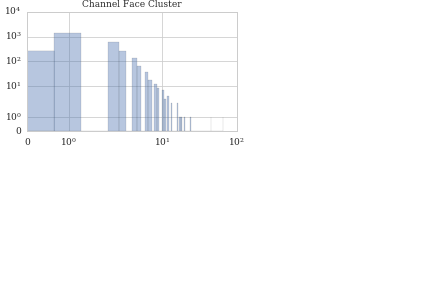

<IPython.core.display.Javascript object>


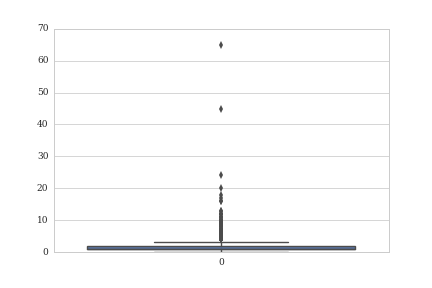

<IPython.core.display.Javascript object>


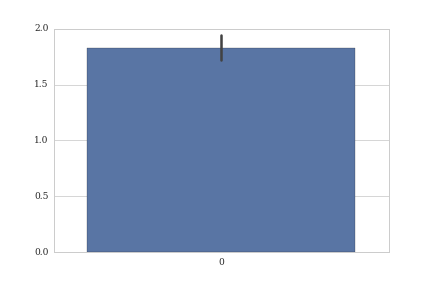

In [30]:
fig = plt.figure()
ax = sns.distplot(df_channel_cluster['n_cluster'], kde=False, bins=100)
ax.set_xlabel('Cluster')
ax.set_ylabel('Channel')
ax.set_xscale('symlog')
ax.set_yscale('symlog')

plt.title('Channel Face Cluster')
save_plot('channel_nof_face_cluster.pdf', fig, s_width, s_height)

fig = plt.figure()
sns.boxplot(data=df_channel_cluster['n_cluster'])

fig = plt.figure()
sns.barplot(data=df_channel_cluster['n_cluster'], ci=99)

In [32]:
degree_sequence=sorted(nx.degree(Gf).values(),reverse=True) # degree sequence
out_degree_sequence=sorted(Gf.out_degree().values(),reverse=True) # degree sequence
in_degree_sequence=sorted(Gf.in_degree().values(),reverse=True) # degree sequence


<IPython.core.display.Javascript object>


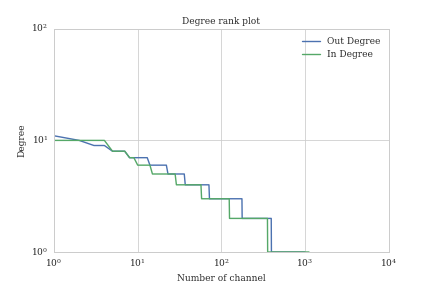

In [33]:
fig = plt.figure()
#plt.loglog(degree_sequence, label='Sum Degree')
plt.loglog(out_degree_sequence, label='Out Degree')
plt.loglog(in_degree_sequence, label='In Degree')
plt.title("Degree rank plot")
plt.ylabel("Degree")
plt.xlabel("Number of channel")
plt.legend()

<IPython.core.display.Javascript object>


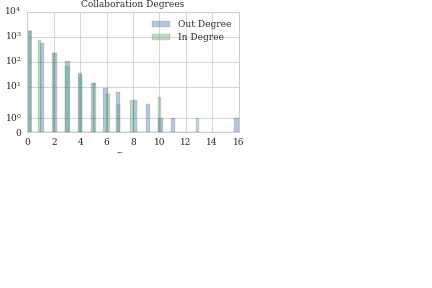

Out degree:                  0
count  2775.000000
mean      0.622703
std       1.153655
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max      16.000000 0    0.0
dtype: float64
In degree:                  0
count  2775.000000
mean      0.622703
std       1.050624
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max      13.000000 0    0.0
dtype: float64


In [34]:
#ax.set_xscale('log') #, basex=2)
#ax.set_yscale('log')

fig = plt.figure()
ax1 = sns.distplot(out_degree_sequence, kde=False, label='Out Degree')

ax1 = sns.distplot(in_degree_sequence, kde=False, label='In Degree')
ax1.set_xlabel('Degree')
ax1.set_ylabel('Number of Channel')
#ax1.set_xscale('log')
ax1.set_yscale('symlog')
ax1.legend()
plt.title('Collaboration Degrees')

save_plot('collab_in_out_degrees.pdf', fig, s_width, s_height)

print 'Out degree:', pa.DataFrame(out_degree_sequence).describe(), pa.DataFrame(out_degree_sequence).median()
print 'In degree:', pa.DataFrame(in_degree_sequence).describe(), pa.DataFrame(in_degree_sequence).median()

#fig.set_size_inches(width, height)
#fig = plt.figure()
#ax2 = sns.distplot(degree_sequence, hist=False, label='Sum Degree')
#ax22 = sns.distplot(out_degree_sequence, hist=False, label='Out Degree')
#ax23 = sns.distplot(in_degree_sequence, hist=False, label='In Degree')
#ax23.legend()

#fig = plt.figure()
#ax3 = sns.distplot(degree_sequence)

In [35]:
# actual collabs list, edges list

def func(graph):
    data = []

    for e in graph.edges(data=True):
        item = {}
        item['from'] = e[0]
        item['to'] = e[1]
        item['cluster'] = e[2]['cluster']
        item['weight'] = e[2]['weight']
        if isinstance(e[2]['videos'], list):
            item['videos'] = e[2]['videos']
        else:
           item['videos'] = [e[2]['videos']]
        
        item['from_network'] = graph.node[e[0]]['network']
        if isinstance(graph.node[e[0]]['cluster'], list):
            item['from_cluster'] = graph.node[e[0]]['cluster'] 
        else:
            item['from_cluster'] = [graph.node[e[0]]['cluster']]

        item['from_popularity'] = df_channel.ix[e[0]].popularity
        item['from_category'] = df_channel.ix[e[0]].category
        item['from_topic'] =  df_channel.ix[e[0]].topicIds

        item['to_network'] = graph.node[e[1]]['network']
        if isinstance(graph.node[e[0]]['cluster'], list):
            item['to_cluster'] = graph.node[e[1]]['cluster'] 
        else:
            item['to_cluster'] = [graph.node[e[1]]['cluster']]
            
        item['to_popularity'] = df_channel.ix[e[1]].popularity
        item['to_category'] = df_channel.ix[e[1]].category
        item['to_topic'] = df_channel.ix[e[1]].topicIds
        
        # get list of video ids with collabs somehow here
        data.append(item)

    
    return data


df_graph = pa.DataFrame(func(G))
df_graph.loc[df_graph['from_network'] == 'Maker_Studios', 'from_network'] = 'Maker Studios'
df_graph.loc[df_graph['to_network'] == 'Maker_Studios', 'to_network'] = 'Maker Studios'

df_graph['from_cluster'] = df_graph['from_cluster'].apply(json.dumps)
df_graph['to_cluster'] = df_graph['to_cluster'].apply(json.dumps)
df_graph['videos'] = df_graph['videos'].apply(json.dumps)
df_graph.to_csv(DIR+r'/df_collabs.txt', sep=str('\t'), encoding='utf-8')



df_graph_filtered = pa.DataFrame(func(Gf))
df_graph_filtered.loc[df_graph_filtered['from_network'] == 'Maker_Studios', 'from_network'] = 'Maker Studios'
df_graph_filtered.loc[df_graph_filtered['to_network'] == 'Maker_Studios', 'to_network'] = 'Maker Studios'


df_graph_filtered['from_cluster'] = df_graph_filtered['from_cluster'].apply(json.dumps)
df_graph_filtered['to_cluster'] = df_graph_filtered['to_cluster'].apply(json.dumps)
df_graph_filtered['videos'] = df_graph_filtered['videos'].apply(json.dumps)
df_graph_filtered.to_csv(DIR+r'/df_filtered_collabs.txt', sep=str('\t'), encoding='utf-8')


print len(df_graph)
print len(df_graph_filtered)

df_graph_filtered.head()


#df_graph_filtered[df_graph_filtered.to == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']


3475
1728


,cluster,from,from_category,from_cluster,from_network,from_popularity,from_topic,to,to_category,to_cluster,to_network,to_popularity,to_topic,videos,weight
0,4806,UCw-hc7ZJummS0AvWyjUX56A,Sports,"[""3102"", ""4806"", ""12796""]",None,3,Fitness,UCWYtZYH4kcbMm29liIOSGQQ,Sports,"[""2996"", ""3143"", ""5232"", ""7762""]",BroadbandTV,3,Sports,"[""Q-Z7QYkqn2M""]",1
1,5556,UClpEE-Led9ZK0GJQKvU--3Q,Entertainment,"[""5556"", ""5884"", ""7050""]",Maker Studios,2,Football,UCIKF1msqN7lW9gplsifOPkQ,Entertainment,"[""12627""]",BroadbandTV,3,Music,"[""On4GE5hAU8s""]",1
2,5556,UClpEE-Led9ZK0GJQKvU--3Q,Entertainment,"[""5556"", ""5884"", ""7050""]",Maker Studios,2,Football,UC3M4u8_WwqY-2xDbJXxo5eQ,Gaming,"[""4139"", ""7049""]",OmniaMediaCo,3,Sports game,"[""4cEkXTIcvH4""]",1
3,6135,UCMDz09-3zO1hm1pqRA-Er0A,Entertainment,"[""6135""]",BroadbandTV,3,Lifestyle,UC3fxB7rF6T7wqymKUJxwmXA,Entertainment,"""""",BroadbandTV,3,Lifestyle,"[""C7Waq5ZgqGU""]",1
4,1367,UCUcBFGAfOzut1x4GSWa6Akg,Entertainment,"[""1367"", ""4731"", ""5365"", ""6760""]",Maker Studios,3,Music,UCCk_JV7ar8HlxWZRXQKgS7w,People & Blogs,"""""",BroadbandTV,2,Lifestyle,"[""RJir4ghyTDo""]",1


In [179]:
df_collab_channels = pa.Series([])

df_collab_channels = df_collab_channels.append(df_graph_filtered['to'])
df_collab_channels = df_collab_channels.append(df_graph_filtered['from'])

print len(df_collab_channels.unique())

1599


In [36]:
df_graph_filtered[df_graph_filtered['from'] == 'UC2FfW6_YHXUSfsndM2R37cQ']

df_graph_filtered[df_graph_filtered['from'] == 'UC45zwHCRNT5jA8sC5DUW7oQ']



,cluster,from,from_category,from_cluster,from_network,from_popularity,from_topic,to,to_category,to_cluster,to_network,to_popularity,to_topic,videos,weight
1113,2157,UC45zwHCRNT5jA8sC5DUW7oQ,Comedy,"[""2157""]",Fullscreen,3,Lifestyle,UC2FfW6_YHXUSfsndM2R37cQ,Entertainment,"[""1409""]",None,3,Music of Latin America,"[""F76ntKET30k""]",1


Number of collaborations complete: 7614
Number of collaborations complete, filtered: 3925
Collaborations between channels: count    3475.000000
mean        2.191079
std         4.610916
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       117.000000
Name: weight, dtype: float64
Collaborations between channels, filtered: count    1728.000000
mean        2.271412
std         4.786327
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       117.000000
Name: weight, dtype: float64
Median number of collaborations between channels: 1.0
Median number of collaborations between channels, filtered: 1.0


<IPython.core.display.Javascript object>


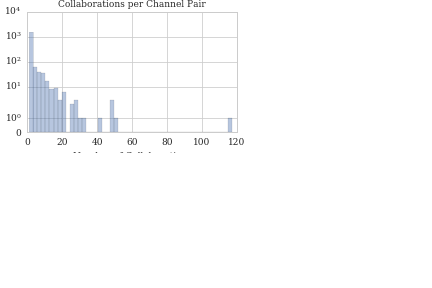

<IPython.core.display.Javascript object>


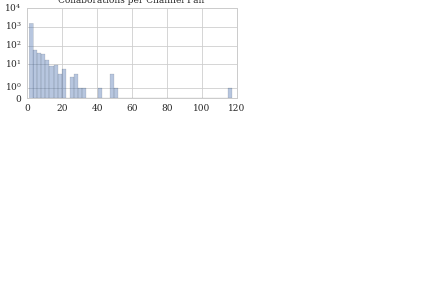

<IPython.core.display.Javascript object>


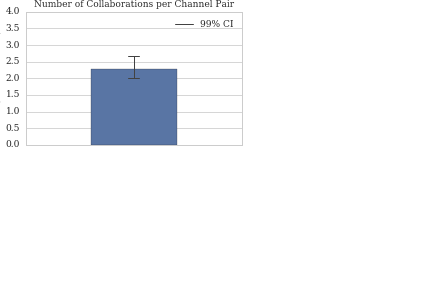

In [150]:
# Statistics about collabs (per channel pair (edges))
# counting collabs between channel, channel can have multiple collabs with different channel etc.

print 'Number of collaborations complete:', df_graph['weight'].sum()
print 'Number of collaborations complete, filtered:', df_graph_filtered['weight'].sum()


print 'Collaborations between channels:', df_graph['weight'].describe()
print 'Collaborations between channels, filtered:', df_graph_filtered['weight'].describe()

print 'Median number of collaborations between channels:', df_graph['weight'].median()
print 'Median number of collaborations between channels, filtered:', df_graph_filtered['weight'].median()


# Number of collaborations per channel pair

fig = plt.figure()
#ax1 = sns.distplot(df_graph['weight'], kde=False)
ax1 = sns.distplot(df_graph_filtered['weight'], kde=False)
ax1.set_xlabel('Number of Collaborations')
ax1.set_ylabel('Frequency')
#ax1.set_xscale('log')
ax1.set_yscale('symlog')
ax1.legend()
plt.title('Collaborations per Channel Pair')
save_plot('collab_channel_pairs.pdf', fig, s_width, s_height)
#fig = plt.figure()
#ax2 = sns.distplot(df_graph['weight'], hist=False)
#ax21 = sns.distplot(df_graph_filtered['weight'], hist=False, )

fig = plt.figure()
#ax1 = sns.distplot(df_graph['weight'], kde=False)
ax1 = sns.distplot(df_graph_filtered['weight'], kde=False)
ax1.set_xlabel('Number of Collaborations')
ax1.set_ylabel('Frequency')
#ax1.set_xscale('log')
ax1.set_yscale('symlog')
ax1.legend()
plt.title('Collaborations per Channel Pair')
save_plot('collab_channel_pairs_s.pdf', fig, s_width, 0.75*s_height)


fig = plt.figure()
ax = sns.barplot(data=df_graph_filtered['weight'], ci=99, errwidth=1., capsize=.05)
plt.legend(["{}% CI".format(99)])
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('mean(Collaborations)')
plt.title('Number of Collaborations per Channel Pair')
ax.set_ylim(0.0, 4.0)
for bar in ax.patches:
    x = bar.get_x()
    width = bar.get_width()
    centre = x+width/2.
    newwidth = width/2
    bar.set_x(centre-newwidth/2.)
    bar.set_width(newwidth)

save_plot('collab_channel_pairs_bar_box.pdf', fig, s_width, s_height)

In [38]:
top_pairs = df_graph_filtered.sort_values(by=['weight'], ascending=False)


def get_name(id):
    with db._session_scope(False) as session:
        return session.query(Channel.title).filter(Channel.id == id).first()[0]
    
top_pairs['from_title'] = top_pairs['from'].apply(get_name)
top_pairs['to_title'] = top_pairs['to'].apply(get_name)

top_pairs[:20].to_csv(DIR+r'/df_most_collabs_top_pairs.txt', sep=str('\t'), encoding='utf-8')

top_pairs[['from_title', 'from_popularity', 'to_title', 'to_popularity', 'weight']][:30]

,from_title,from_popularity,to_title,to_popularity,weight
652,InformOverload,3,iO Trendz,3,117
1252,LandonProduction Vlogs,2,MostAmazingTop10,4,51
1321,FilmRise,2,FilmRise Documentaries,2,49
574,Good Mythical MORE,4,Good Mythical Morning,5,49
1322,FilmRise,2,FilmRise True Crime,2,48
443,Good Mythical Morning,5,Good Mythical MORE,4,42
1490,ChocolaTV,4,Freak TV,3,32
158,Ashley & Nate,3,NatesLife,3,29
797,WengieVlogs,3,Maxmellow,2,28
912,PontiacMadeDDG VLOGS,3,PontiacMadeDDG,3,27


In [39]:
top_pairs['popularity_diff'] = top_pairs.apply(lambda row: abs(row['to_popularity'] - row['from_popularity']), axis=1)
top_pairs.sort_values(by=['popularity_diff', 'weight'], ascending=True)[['from_title', 'from_popularity', 'to_title', 'to_popularity', 'weight']][:30]

,from_title,from_popularity,to_title,to_popularity,weight
1017,TheRealAlexBertie,3,Ash Hardell,3,1
1256,Welcome Jules,3,NAMOR*,3,1
1258,Victor Goes,3,#100 Noção,3,1
1253,Kyo And Ruka,2,Zaunstar,2,1
1226,Diário de Princesas,1,Youtubers Kids BR,1,1
1225,WarLeaks - Daily Military Defense Videos & Com...,3,kamikadzedead,3,1
1255,Welcome Jules,3,SuperDimmix,3,1
1205,MusicNeverSleeps,4,Tiffany Alvord,4,1
1206,SanFrezco,3,Nick SanFrezco,3,1
1240,Sabrina Iorio,3,uJoãozinho Vine,3,1


In [40]:
# check how the names of collab channels differ, channel name in other channel occuring?
for i, row in top_pairs[:20].iterrows():
    if row['from'] in row['to']:
        print row[['from', 'to', 'weight']]
    elif row['to'] in row['from']:
        print row[['from', 'to', 'weight']]


<IPython.core.display.Javascript object>


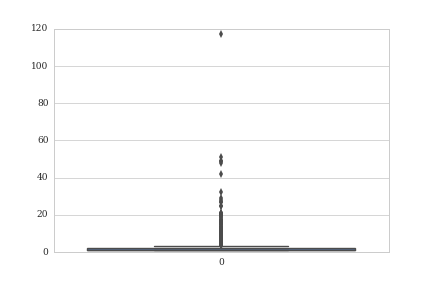

<IPython.core.display.Javascript object>


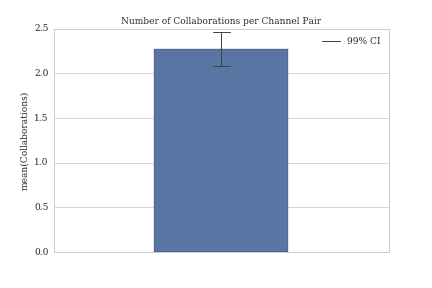

In [41]:
fig = plt.figure()
ax = sns.boxplot(data=df_graph_filtered['weight'])

fig = plt.figure()
ax = sns.barplot(data=df_graph_filtered['weight'], ci=90, errwidth=1., capsize=.05)
plt.legend(["{}% CI".format(99)])
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('mean(Collaborations)')
plt.title('Number of Collaborations per Channel Pair')
for bar in ax.patches:
    x = bar.get_x()
    width = bar.get_width()
    centre = x+width/2.
    newwidth = width/2
    bar.set_x(centre-newwidth/2.)
    bar.set_width(newwidth)

                          in_weight  out_weight  sum_weight
channel                                                    
UCm1LjO7mpzb68Q71PjGleWQ        0.0         0.0         0.0
UCw-hc7ZJummS0AvWyjUX56A        0.0         1.0         1.0
UCJ3_30nK_biup2t7g_3C61g        1.0         0.0         1.0
UCc_JXQMtWfJmQk3XPQ8JVJQ        0.0         0.0         0.0
UC3Nr-TlH0dQD-R7JBdWU00w        0.0         0.0         0.0


<IPython.core.display.Javascript object>


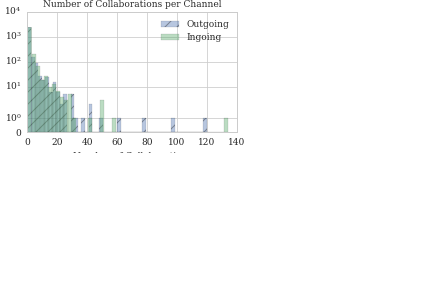

<IPython.core.display.Javascript object>


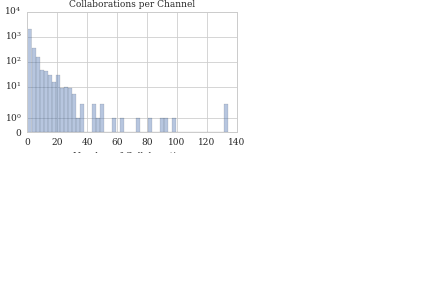

<IPython.core.display.Javascript object>


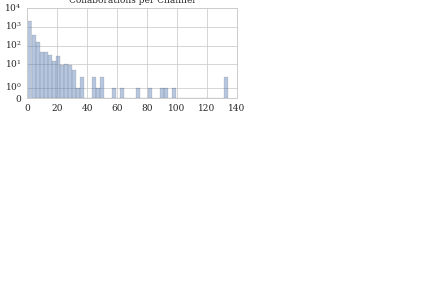

count    2775.000000
mean        2.828829
std         7.234004
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       134.000000
Name: sum_weight, dtype: float64


<IPython.core.display.Javascript object>


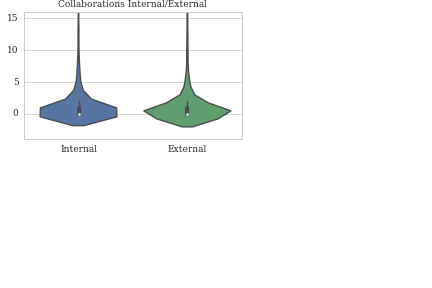

<IPython.core.display.Javascript object>


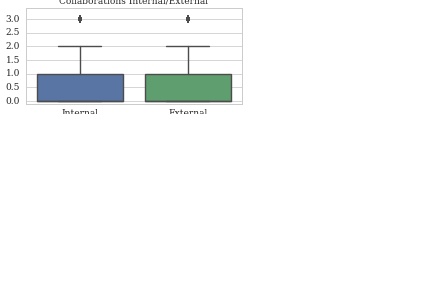

count    2775.000000
mean        1.414414
std         4.486117
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       134.000000
Name: in_weight, dtype: float64
count    2775.000000
mean        1.414414
std         4.941453
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       120.000000
Name: out_weight, dtype: float64


<IPython.core.display.Javascript object>


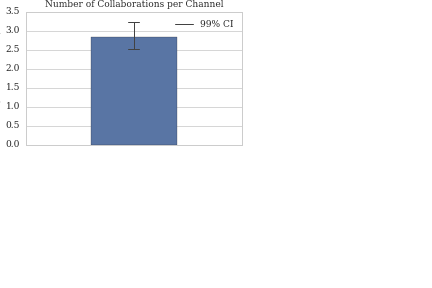

1.0


count    2775.000000
mean        2.828829
std         7.234004
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       134.000000
Name: sum_weight, dtype: float64

In [153]:
# Statistics about channel and their overall collabs (channel wise)
# counting in and outgoing overall collabs per channel (every channel has single value)

# trenne out and ingoing?
# sum ingoing weights of every node in the graph -> in, out going weight -> overall collabs

df_channel_collab_weights = pa.DataFrame(G.nodes(),columns=['channel']) # use all channel list not only from collab graph?
df_channel_collab_weights = df_channel_collab_weights.set_index(['channel'])

df_channel_collab_weights_filtered = pa.DataFrame(Gf.nodes(),columns=['channel'])
df_channel_collab_weights_filtered = df_channel_collab_weights_filtered.set_index(['channel'])

df_channel_collab_weights_filtered['in_weight'] = np.nan
df_channel_collab_weights_filtered['out_weight'] = np.nan
df_channel_collab_weights_filtered['sum_weight'] = np.nan

for node in Gf.nodes():
    outs = Gf.out_edges(node)
    out_weight = 0
    for e in outs:
        out_weight += Gf.get_edge_data(e[0], e[1])['weight']

    ins = Gf.in_edges(node)
    in_weight = 0
    for e in ins:
        in_weight += Gf.get_edge_data(e[0], e[1])['weight']

    df_channel_collab_weights_filtered.loc[node, 'in_weight'] = in_weight
    df_channel_collab_weights_filtered.loc[node, 'out_weight'] = out_weight
    df_channel_collab_weights_filtered.loc[node, 'sum_weight'] = in_weight+out_weight
    

print df_channel_collab_weights_filtered.head()

fig = plt.figure()
ax1 = sns.distplot(df_channel_collab_weights_filtered['out_weight'], kde=False, label='Outgoing')

# Define some hatches
hatches = ['-', '+', 'x', '\\', '*', 'o']

# Loop over the bars
for i,thisbar in enumerate(ax1.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch('//')
    
ax1 = sns.distplot(df_channel_collab_weights_filtered['in_weight'], kde=False, label='Ingoing')
ax1.set_xlabel('Number of Collaborations')
ax1.set_ylabel('Channel')
#ax1.set_xscale('log')
ax1.set_yscale('symlog')
ax1.legend()
plt.title('Number of Collaborations per Channel')
save_plot('collab_in_out_collabs.pdf', fig, s_width, s_height)

fig = plt.figure()
ax1 = sns.distplot(df_channel_collab_weights_filtered['sum_weight'], kde=False)
ax1.set_xlabel('Number of Collaborations')
ax1.set_ylabel('Frequency')
#ax1.set_xscale('log')
ax1.set_yscale('symlog')
ax1.legend()
plt.title('Collaborations per Channel')
save_plot('collab_nof_collabs_per_channel.pdf', fig, s_width, s_height)

fig = plt.figure()
ax1 = sns.distplot(df_channel_collab_weights_filtered['sum_weight'], kde=False)
ax1.set_xlabel('Number of Collaborations')
ax1.set_ylabel('Frequency')
#ax1.set_xscale('log')
ax1.set_yscale('symlog')
ax1.legend()
plt.title('Collaborations per Channel')
save_plot('collab_nof_collabs_per_channel_s.pdf', fig, s_width, 0.75*s_height)

print df_channel_collab_weights_filtered['sum_weight'].describe()

df_test_weights = []
for i, row in df_channel_collab_weights_filtered.iterrows():
    df_test_weights.append((row['in_weight'], 'in_weight'))
    df_test_weights.append((row['out_weight'], 'out_weight'))
df_test_weights = pa.DataFrame(df_test_weights, columns=['weight', 'direction'])
df_test_weights.head()



fig = plt.figure()
ax = sns.violinplot(x='direction', y='weight', data=df_test_weights)
ax.set_xticklabels(['Internal', 'External'])
ax.set_ylabel('Number of Collaborations')
ax.set_xlabel('')
plt.title('Collaborations Internal/External')
ax.set_ylim([-4, 16])
save_plot('collab_in_out_collabs_box_violin.pdf', fig, s_width, s_height)

fig = plt.figure()
ax = sns.boxplot(x='direction', y='weight', data=df_test_weights)
print df_channel_collab_weights_filtered['in_weight'].describe()
print df_channel_collab_weights_filtered['out_weight'].describe()

ax.set_xticklabels(['Internal', 'External'])
ax.set_ylabel('Number of Collaborations')
ax.set_xlabel('')
plt.title('Collaborations Internal/External')
ax.set_ylim([-0.1, 3.4])
save_plot('collab_in_out_collabs_box_s.pdf', fig, s_width, 0.75*s_height)

fig = plt.figure()
ax = sns.barplot(data=df_channel_collab_weights_filtered['sum_weight'], ci=99, errwidth=1., capsize=.05)
plt.legend(["{}% CI".format(99)])
ax.set_xlabel('')
ax.set_xticklabels('')
ax.set_ylabel('mean(Collaborations)')
plt.title('Number of Collaborations per Channel')

for bar in ax.patches:
    x = bar.get_x()
    width = bar.get_width()
    centre = x+width/2.
    newwidth = width/2
    bar.set_x(centre-newwidth/2.)
    bar.set_width(newwidth)

save_plot('collab_nof_collabs_per_channel_bar_box.pdf', fig, s_width, s_height)

print df_channel_collab_weights_filtered['sum_weight'].median()
df_channel_collab_weights_filtered['sum_weight'].describe()

In [43]:
sorted_collabs =  df_channel_collab_weights_filtered['sum_weight'].sort_values(ascending=False)

sorted_collabs = sorted_collabs[:10]
print sorted_collabs
#most_collabs = pa.DataFrame(['channel0', 'channel1', 'nof'])
most_collabs = []

for index1, sumw in sorted_collabs.iteritems():
    #print index1, sumw
    froms = df_graph_filtered[df_graph_filtered['from'] == index1][['to', 'weight', 'cluster']]
    tos = df_graph_filtered[df_graph_filtered.to == index1][['from', 'weight', 'cluster']]
    
    for index2, row in froms.iterrows():
        most_collabs.append( (index1, sumw,  row['to'], row['weight'], row['cluster']) )
    
    for index2, row in tos.iterrows():
        most_collabs.append( (index1, sumw, row['from'], row['weight'], row['cluster']) )
    
most_collabs = pa.DataFrame(most_collabs)

#most_collabs.set_index([0, 1], inplace=True)

#most_collabs = most_collabs.reset_index()


def get_name(id):
    with db._session_scope(False) as session:
        return session.query(Channel.title).filter(Channel.id == id).first()[0]
    
most_collabs[0] = most_collabs[0].apply(get_name)
most_collabs[2] = most_collabs[2].apply(get_name)


most_collabs.columns = ['channel0', 'total', 'channel1', 'count', 'cluster']

most_collabs.set_index(['channel0', 'total', ], inplace=True)

most_collabs.to_csv(DIR+r'/df_most_collabs_top.txt', sep=str('\t'), encoding='utf-8')

most_collabs


channel
UCIZSqPHF-R9m3X5o0VPKFdg    134.0
UC-NINtNMPM75eaqh07RCy_Q    133.0
UCz_BJGTYrM4ntr7vsrsjfLw     97.0
UC4PooiX37Pld1T8J5SYT-SQ     93.0
UCzpCc5n9hqiVC7HhPwcIKEg     91.0
UCoKGanMmrKj8RAqAwS5vRug     82.0
UCBINYCmwE29fBXCpUI8DgTA     74.0
UCfPhyExfcaqJBKc3HO3cNBw     63.0
UCNRfqSkBqZR8Ge_QnfwqgFQ     57.0
UCU4BHh9Dwfd7-I_xTZ5037Q     50.0
Name: sum_weight, dtype: float64


channel1  count cluster
channel0               total                                                  
iO Trendz              134.0                 MyCupcakeAddiction      1    4776
                       134.0                    SuperwomanVlogs      1    7489
                       134.0                  Michael McCrudden      1    7598
                       134.0                             Scarce      1    9356
                       134.0                     InformOverload    117    7556
                       134.0                          PewDiePie      1    5367
                       134.0                          SHAYTARDS      1    5257
                       134.0                      Pabllo Vittar      1    3053
                       134.0                       DJ Akademiks      1    4716
                       134.0                   MostAmazingTop10      9    5264
InformOverload         133.0                   InformOverload 2      2    7556
                       133.0             LandonProduction Vlogs      1    5975
                       133.0                          iO Trendz    117    7556
                       133.0                    HES19Motivation      1     108
                       133.0  Bando de Quadrados - Nerd Cristão      1    3447
                       133.0                          Be Amazed      1    3493
                       133.0                     Monster Energy      1    5247
                       133.0                          SHAYTARDS      2    5257
                       133.0                   MostAmazingTop10      6    8709
                       133.0                      dangmattsmith      1    5508
FilmRise               97.0              FilmRise Documentaries     49     252
                       97.0                 FilmRise True Crime     48     252
Good Mythical Morning  93.0                         Isa Marcial      1    4933
                       93.0                  Good Mythical MORE     42   13327
                       93.0                         Terror Tube      1     104
                       93.0                  Good Mythical MORE     49    8617
Good Mythical MORE     91.0               Good Mythical Morning     49    8617
                       91.0               Good Mythical Morning     42   13327
LandonProduction Vlogs 82.0                    LandonProduction     27    4811
                       82.0                    MostAmazingTop10     51    4811
                       82.0                      InformOverload      1    5975
                       82.0                    MostAmazingTop10      2    8709
                       82.0                    LandonProduction      1    4958
MostAmazingTop10       74.0              LandonProduction Vlogs      2    8709
                       74.0                      InformOverload      6    8709
                       74.0                           iO Trendz      9    5264
                       74.0                        Leandro Osti      1    1166
                       74.0                      CHEF MAMA ROSA      1    2188
                       74.0                 Black Pigeon Speaks      1    1087
                       74.0                Just For Laughs Gags      1     668
                       74.0                      Monster Energy      1    5247
                       74.0                                 CBR      1    1996
                       74.0              LandonProduction Vlogs     51    4811
JustKiddingNews        63.0                    JustKiddingFilms      2   11464
                       63.0                              Joe Jo      1   10663
                       63.0                       James Rodolfo     13   12825
                       63.0                          Bart & Geo     21   11464
                       63.0                         Tiff & Case      6    5428
                       63.0                    JustKiddingParty     15   11464
                       63.

In [158]:
# number of collabs/ Number of videos ratio

# number of collabs -> channel weights (count only in-edges? because in-edges are own videos, 
# out would include videos from othe channel)
# number of videos -> DB, other DF

df_channel_collab_weights_filtered['video/collab ratio'] = np.nan
df_channel_collab_weights_filtered.loc[:, 'nof_videos'] = np.nan

for node in Gf.nodes():
    in_weight = df_channel_collab_weights_filtered.loc[node, 'in_weight']
    with db._session_scope(False) as session:
        nof_videos = session.query(Video.id).filter(Video.channelID == node).count()
    df_channel_collab_weights_filtered.loc[node, 'nof_videos'] = nof_videos
    #print nof_videos, in_weight, in_weight/nof_videos
    df_channel_collab_weights_filtered.loc[node, 'video/collab ratio'] = in_weight / nof_videos

    
#print df_channel_collab_weights[['in_weight', 'out_weight', 'nof_videos', 'video/collab ratio']].sort_values(by='video/collab ratio', ascending=False)

<IPython.core.display.Javascript object>


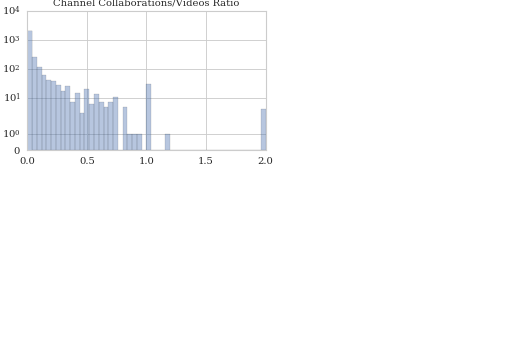

<IPython.core.display.Javascript object>


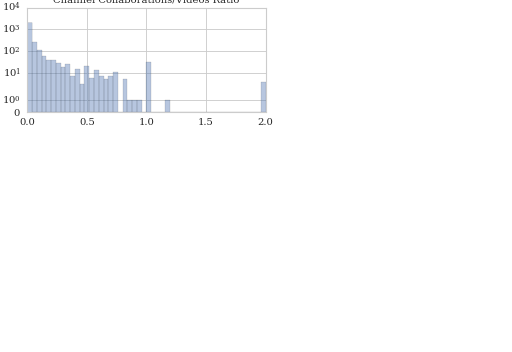

count    2775.000000
mean        0.063742
std         0.175167
min         0.000000
25%         0.000000
50%         0.000000
75%         0.043478
max         2.000000
Name: video/collab ratio, dtype: float64

In [159]:
#number of collabs/ Number of videos ratio

fig = plt.figure()
ax1 = sns.distplot(df_channel_collab_weights_filtered['video/collab ratio'], kde=False)
ax1.set_xlabel('Collaboration/Video Ratio')
ax1.set_ylabel('Number of Channel')
#ax1.set_xscale('log')
ax1.set_yscale('symlog')
ax1.legend()
plt.title('Channel Collaborations/Videos Ratio')
save_plot('collab_video_ratios.pdf', fig, s_width, s_height)


fig = plt.figure()
ax1 = sns.distplot(df_channel_collab_weights_filtered['video/collab ratio'], kde=False)
ax1.set_xlabel('Collaboration/Video Ratio')
ax1.set_ylabel('Number of Channel')
#ax1.set_xscale('log')
ax1.set_yscale('symlog')
ax1.legend()
plt.title('Channel Collaborations/Videos Ratio')
save_plot('collab_video_ratios_s.pdf', fig, s_width, 0.75*s_height)

#fig = plt.figure()
#ax2 = sns.distplot(df_channel_collab_weights_filtered['video/collab ratio'], hist=False)
#ax2.set_yscale('log')
#ax2.set_xscale('log')

df_channel_collab_weights_filtered['video/collab ratio'].describe()

In [46]:
# assigns network and popularity in channel list df_channel_collab_weights_filtered


df_channel_collab_weights_filtered['network'] = np.nan
df_channel_collab_weights_filtered['popularity'] = np.nan

for index, row in df_channel_collab_weights_filtered.iterrows():
    df_channel_collab_weights_filtered.loc[index, 'network'] = df_channel.loc[index, 'network']
    df_channel_collab_weights_filtered.loc[index, 'popularity'] = df_channel.loc[index, 'popularity']


# Collabs by network
# number of collabs complete (all channels) per network, dist.
networks = []
for name, group in df_channel_collab_weights_filtered.groupby(['network']):
    #print name, group['sum_weight'].sum()
    networks.append((name, group['in_weight'].sum(), group['out_weight'].sum()))
df_network_collabs = pa.DataFrame(networks, columns=['network', 'in_collabs', 'out_collabs'])
df_network_collabs = df_network_collabs.set_index(['network'])

# number of collabs by popularity, per popularity class -> in or outgoing collabs? both?
popularitys = []
for name, group in df_channel_collab_weights_filtered.groupby(['popularity']):
    #print name, group['sum_weight'].sum()
    popularitys.append((name, group['in_weight'].sum(), group['out_weight'].sum()))
df_popularitys_collabs = pa.DataFrame(popularitys, columns=['popularity', 'in_collabs', 'out_collabs'])
df_popularitys_collabs = df_popularitys_collabs.set_index(['popularity'])

print df_network_collabs.head()
print len(df_network_collabs)
print df_popularitys_collabs.head()
# Number of collabs between channel in their own network, and collabs over networks

                        in_collabs  out_collabs
network                                        
1l1lv2tvbn7LsHWoygrwgA         0.0          0.0
2btube                         3.0          1.0
63vOrQKSnHPhvqmEekGPOQ         0.0          0.0
AGE Network                    0.0          0.0
AIR                           30.0          0.0
203
            in_collabs  out_collabs
popularity                         
0.0               71.0         53.0
1.0              187.0        142.0
2.0              847.0        828.0
3.0             1914.0       1929.0
4.0              827.0        902.0


In [47]:
print df_network_collabs.describe()

print df_popularitys_collabs.describe()

        in_collabs  out_collabs
count   203.000000   203.000000
mean     19.334975    19.334975
std     112.487474   115.571615
min       0.000000     0.000000
25%       0.000000     0.000000
50%       1.000000     0.000000
75%       3.000000     2.000000
max    1106.000000  1037.000000
        in_collabs  out_collabs
count     7.000000     7.000000
mean    560.714286   560.714286
std     696.386558   712.598464
min       3.000000     5.000000
25%      73.500000    59.500000
50%     187.000000   142.000000
75%     837.000000   865.000000
max    1914.000000  1929.000000


<IPython.core.display.Javascript object>


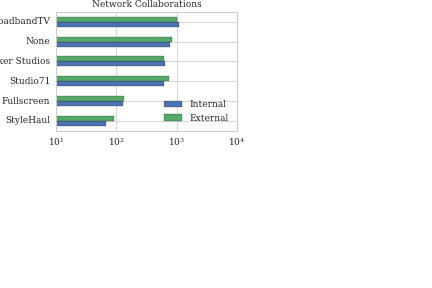

<IPython.core.display.Javascript object>


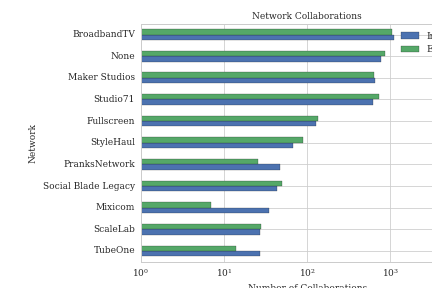

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


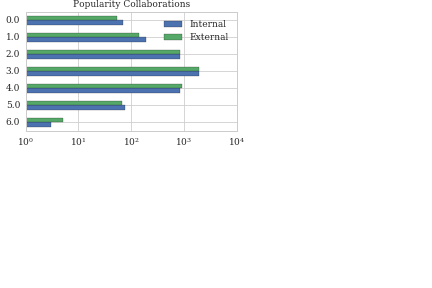

In [48]:
fig, axes = plt.subplots()
ax = df_network_collabs[ (df_network_collabs.in_collabs + df_network_collabs.out_collabs) > 100].sort_values(by=['in_collabs', 'out_collabs'], ascending=True).plot(ax=axes, kind='barh')
ax.set_xlabel('Number of Collaborations')
ax.set_ylabel('Network')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend(loc=0, labels=['Internal', 'External'])
plt.title('Network Collaborations')
plt.tight_layout()
save_plot('collab_in_out_networks.pdf', fig, s_width, s_height)

fig, axes = plt.subplots()
ax = df_network_collabs[ (df_network_collabs.in_collabs + df_network_collabs.out_collabs) > 40].sort_values(by=['in_collabs', 'out_collabs'], ascending=True).plot(ax=axes, kind='barh')
ax.set_xlabel('Number of Collaborations')
ax.set_ylabel('Network')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend(loc=0, labels=['Internal', 'External'])
plt.title('Network Collaborations')
plt.tight_layout()
save_plot('collab_in_out_networks_big.pdf', fig, x_width, x_height)

fig, axes = plt.subplots()
ax1 = df_popularitys_collabs.sort_index(ascending=False).plot(ax=axes,kind='barh')
ax1.set_xlabel('Number of Collaborations')
ax1.set_ylabel('Popularity')
ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.legend(loc=0, labels=['Internal', 'External'])
plt.title('Popularity Collaborations')
plt.tight_layout()
save_plot('collab_in_out_popularity.pdf', fig, s_width, s_height)

[[   1.    4.   12.   15.    4.    0.    0.]
 [   6.   11.   24.   38.   10.    0.    0.]
 [  10.   22.  109.  191.   53.    1.    1.]
 [  12.   41.  196.  430.  157.    3.    0.]
 [   3.   11.   48.  170.  115.    7.    2.]
 [   0.    1.    3.    6.    7.    0.    0.]
 [   0.    0.    1.    3.    0.    0.    0.]]


<IPython.core.display.Javascript object>


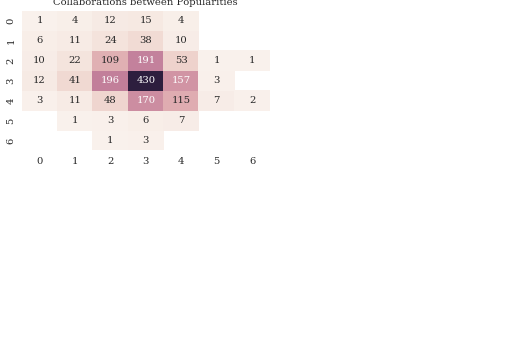

In [174]:
# Collabs between popularitys
pops = df_graph_filtered[['from_popularity', 'to_popularity']]
y = pops['from_popularity'].nunique()
x = pops['to_popularity'].nunique()
arr = np.zeros((y, x))

for row in pops.iterrows():
    #print row[0], row[1][0], row[1][1]
    arr[row[1][0], row[1][1]] += 1

print arr
# divide every arr field through the number of videos in this pair?
df_arr = pa.DataFrame(arr)

fig = plt.figure()
ax = sns.heatmap(df_arr, annot=True, fmt='g', cbar=False, mask=df_arr<=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
#ax.set_xscale('log')
#ax1.set_yscale('log')
plt.title('Collaborations between Popularities')
plt.tight_layout()
save_plot('collab_popularity_heatmap.pdf', fig, s_width, s_height)

[[   1.    4.   12.   15.    4.    0.    0.]
 [   6.   11.   24.   38.   10.    0.    0.]
 [  10.   22.  109.  191.   53.    1.    1.]
 [  12.   41.  196.  430.  157.    3.    0.]
 [   3.   11.   48.  170.  115.    7.    2.]
 [   0.    1.    3.    6.    7.    0.    0.]
 [   0.    0.    1.    3.    0.    0.    0.]]
1728.0


<IPython.core.display.Javascript object>


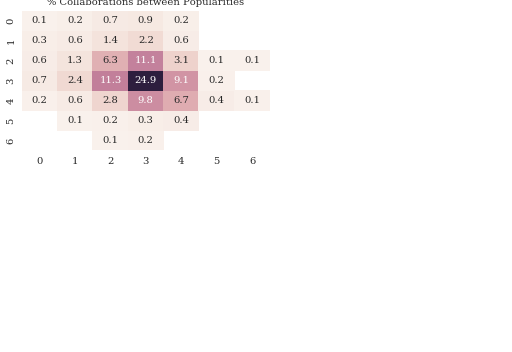

In [190]:
# Collabs between popularitys
pops = df_graph_filtered[['from_popularity', 'to_popularity']]
y = pops['from_popularity'].nunique()
x = pops['to_popularity'].nunique()
arr = np.zeros((y, x))

sum = 0.0

for row in pops.iterrows():
    #print row[0], row[1][0], row[1][1]
    arr[row[1][0], row[1][1]] += 1
    sum += 1

print arr
print sum
arr_p = arr / sum * 100.0
# divide every arr field through the number of videos in this pair?
df_arr = pa.DataFrame(arr_p)

fig = plt.figure()
ax = sns.heatmap(df_arr, annot=True, fmt='.1f', cbar=False, mask=df_arr<=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
#ax.set_xscale('log')
#ax1.set_yscale('log')
plt.title('% Collaborations between Popularities')
plt.tight_layout()
save_plot('collab_popularity_heatmap_perc.pdf', fig, s_width, s_height)

<IPython.core.display.Javascript object>


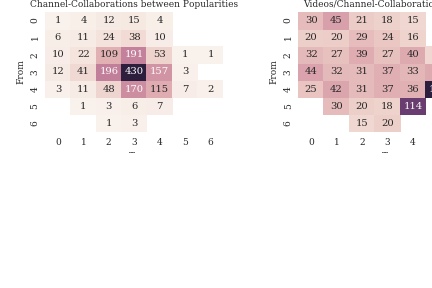

<IPython.core.display.Javascript object>


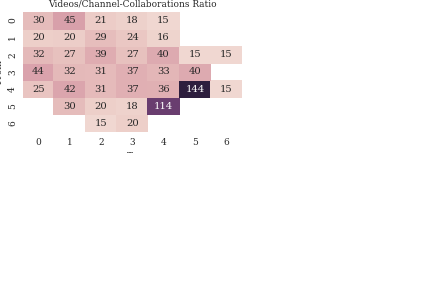

In [50]:
# Collabs between popularitys
pops = df_graph_filtered[['from_popularity', 'to_popularity', 'videos']]
y = pops['from_popularity'].nunique()
x = pops['to_popularity'].nunique()
#vids = pops['videos'].apply(len)

arr = np.zeros((y, x)) # number of channel-pairs collaborating
arr_div = np.zeros((y, x)) # number of videos

for row in pops.iterrows():
    #print row[0], row[1][0], row[1][1]
    arr[row[1][0], row[1][1]] += 1
    arr_div[row[1][0], row[1][1]] += len(row[1][2])

#print arr


df_arr1 = pa.DataFrame(arr)

fig, (ax1, ax2) = plt.subplots(ncols=2)

sns.heatmap(df_arr1, annot=True, fmt='.0f', cbar=False, mask=df_arr<=0, ax=ax1)
ax1.set_xlabel('To')
ax1.set_ylabel('From')
#ax.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_title('Channel-Collaborations between Popularities')
plt.tight_layout()

#arr = (arr - np.mean(arr)) / np.std(arr)
#arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

#arr_div = (arr_div - np.mean(arr_div)) / np.std(arr_div)
#arr_div = (arr_div-np.min(arr_div))/(np.max(arr_div)-np.min(arr_div))

arr[arr == 0] = 0.000000001

arr_test = arr_div / arr

#print arr_div

#print arr_test


df_arr = pa.DataFrame(arr_test)

sns.heatmap(df_arr, annot=True, fmt='.0f', cbar=False, mask=df_arr<=0, ax=ax2)
ax2.set_xlabel('To')
ax2.set_ylabel('From')
#ax.set_xscale('log')
#ax1.set_yscale('log')
ax2.set_title('Videos/Channel-Collaborations Ratio')
plt.tight_layout()
save_plot('collab_popularity_heatmap_normalized_combine.pdf', fig, 2*s_width, s_height)

fig = plt.figure()
ax =sns.heatmap(df_arr, annot=True, fmt='.0f', cbar=False, mask=df_arr<=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
#ax.set_xscale('log')
#ax1.set_yscale('log')
ax.set_title('Videos/Channel-Collaborations Ratio')
plt.tight_layout()
save_plot('collab_popularity_heatmap_normalized.pdf', fig, s_width, s_height)

In [51]:
bins = [0, 1.0e+3, 1.0e+4, 1.0e+5, 1.0e+6, 1.0e+7, 5.0e+7, 1.0e+8]
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)


for i, (a, b) in enumerate(pairwise(bins)):
    print i,':', a, b

0 : 0 1000.0
1 : 1000.0 10000.0
2 : 10000.0 100000.0
3 : 100000.0 1000000.0
4 : 1000000.0 10000000.0
5 : 10000000.0 50000000.0
6 : 50000000.0 100000000.0


<IPython.core.display.Javascript object>


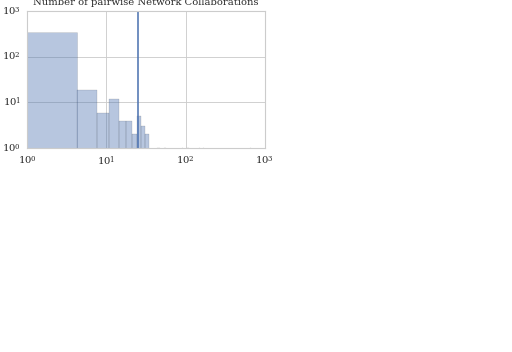

404
36


In [202]:
# network collabs
    
network_pairs = []
for name, group in df_graph_filtered.groupby(['from_network', 'to_network']):
    network_pairs.append((name[0], name[1], group['weight'].sum()))
    
df_network_pairs_collabs = pa.DataFrame(network_pairs, columns=['from_network','to_network', 'nof_collabs'])

#df_network_pairs_collabs.plot()

fig = plt.figure()
ax = sns.distplot(df_network_pairs_collabs['nof_collabs'], kde=False, bins=200)
ax.set_xlabel('Number of Collaborations')
ax.set_ylabel('Network Pairs')
ax.set_xscale('log')
ax.set_yscale('log')
plt.title('Number of pairwise Network Collaborations')
plt.tight_layout()
plt.axvline(x=25.0)
save_plot('collab_network_pairs.pdf', fig, s_width, s_height)

#print df_network_pairs_collabs.sort_values(by='nof_collabs', ascending=False).head()
print len(df_network_pairs_collabs)

df_network_collabs_mask = df_network_pairs_collabs[df_network_pairs_collabs.nof_collabs > 12]
#print df_network_collabs_mask.sort_values(by='nof_collabs', ascending=False).head()
print len(df_network_collabs_mask)

#df_network_pairs_collabs[df_network_pairs_collabs.from_network=='AIR']


1192
10
14
225 225


<IPython.core.display.Javascript object>


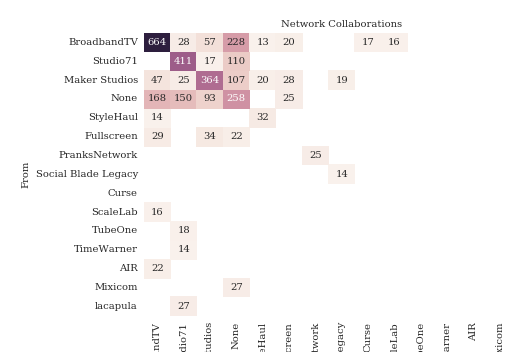

<IPython.core.display.Javascript object>


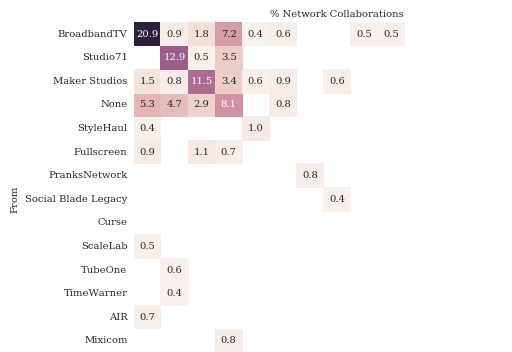

In [208]:
# Collabs between networks

def f(x1, x2):
    return ((df_network_collabs_mask['from_network'] == x1) & (df_network_collabs_mask['to_network'] == x2)).any()

df_graph_collabs_vis = df_graph_filtered[df_graph_filtered[['from_network','to_network']].apply(lambda x: f(*x), axis=1)]


network_test = []
for name, group in df_graph_collabs_vis.groupby(['from_network', 'to_network']):
    network_test.append((name[0], name[1], group['weight'].sum()))

    
df_network_test_collabs = pa.DataFrame(network_test, columns=['from_network','to_network', 'nof_collabs'])

froms = df_network_test_collabs['from_network'].values
tos = df_network_test_collabs['to_network'].values

network_set = []
network_set.extend(froms)
network_set.extend(tos)
network_set = list(set(network_set))

new_index = pa.MultiIndex.from_product([network_set, network_set], names=['from_network', 'to_network'])

df_network_test_collabs = df_network_test_collabs.set_index(['from_network', 'to_network']).reindex(new_index).reset_index()

df_network_test_collabs = df_network_test_collabs.set_index(['from_network', 'to_network'])
df_network_test_collabs = df_network_test_collabs.sort_values(by='nof_collabs', ascending=False)


def unique(array):
    uniq, index = np.unique(array, return_index=True)
    return uniq[index.argsort()]

#print df_graph_collabs_vis.head()
print len(df_graph_collabs_vis)
print df_graph_collabs_vis['from_network'].nunique()
print df_graph_collabs_vis['to_network'].nunique()


index_test = df_network_test_collabs.index.values
index_test1, index_test2 = zip(*index_test)

print len(index_test1), len(index_test2)

index_test1 = unique(index_test1)
index_test2 = unique(index_test2)

#print index_test1
#print index_test2

#print len(index_test1), len(index_test2)

test = df_network_test_collabs.unstack(0)
test = test.reindex(index_test1)
#print test.index
new_test = []

for lvl in index_test1:
    vals = test[('nof_collabs', lvl)]

    new_test.append(vals)
    #new_test.append(test[('nof_collabs', lvl)])

new_test = pa.DataFrame(new_test).T

new_test_2 = new_test.copy()

sum = np.nansum(new_test.values)

#print new_test.index
#new_test['nof_collabs'] = new_test['nof_collabs'].apply(lambda x: x / sum * 100.0)

for i, row in new_test_2.iterrows():
    for j, item in row.iteritems():
        #v = 0
        #for l in df_graph_filtered[(df_graph_filtered.from_network==i) & (df_graph_filtered.to_network==j[1])]['videos']:
        #    v += len(l)
        #print item, v
        #if item and v:
        #    new_test_2.loc[(i, j)] = v/item #item/v
        #else:
        #    new_test_2.loc[(i, j)] = np.nan
        new_test_2.loc[(i, j)] = item / sum * 100.0
    
fig = plt.figure()
ax = sns.heatmap(new_test, annot=True, yticklabels=index_test1, xticklabels=index_test1, fmt='g', cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
plt.title('Network Collaborations')
plt.tight_layout()

save_plot('collab_network_heatmap.pdf', fig, 1*x_width, 1.5*x_height)


fig = plt.figure()
ax = sns.heatmap(new_test_2, annot=True, yticklabels=index_test1, xticklabels=index_test1, fmt='.1f', cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
plt.title('% Network Collaborations')
plt.tight_layout()
save_plot('collab_network_heatmap_perc.pdf', fig, 1*x_width, 1.5*x_height)

#print index_test1
#print index_test2

<IPython.core.display.Javascript object>


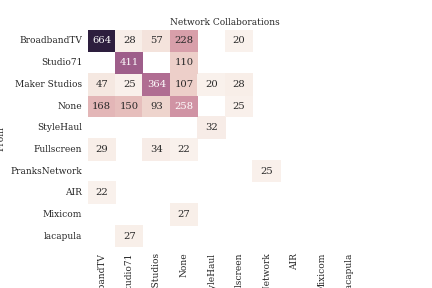

<IPython.core.display.Javascript object>


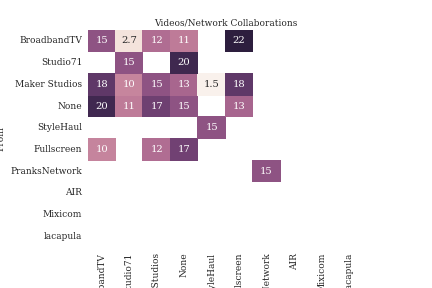

,"(nof_collabs, BroadbandTV)","(nof_collabs, Studio71)","(nof_collabs, Maker Studios)","(nof_collabs, None)","(nof_collabs, StyleHaul)","(nof_collabs, Fullscreen)","(nof_collabs, PranksNetwork)","(nof_collabs, AIR)","(nof_collabs, Mixicom)","(nof_collabs, lacapula)"
to_network,,,,,,,,,,
BroadbandTV,664.0,28.0,57.0,228.0,NaN,20.0,NaN,NaN,NaN,NaN
Studio71,NaN,411.0,NaN,110.0,NaN,NaN,NaN,NaN,NaN,NaN
Maker Studios,47.0,25.0,364.0,107.0,20.0,28.0,NaN,NaN,NaN,NaN
None,168.0,150.0,93.0,258.0,NaN,25.0,NaN,NaN,NaN,NaN
StyleHaul,NaN,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN
Fullscreen,29.0,NaN,34.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN
PranksNetwork,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN
AIR,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mixicom,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
fig = plt.figure()
ax = sns.heatmap(new_test, annot=True, yticklabels=index_test1, xticklabels=index_test1, fmt='g', cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
plt.title('Network Collaborations')
plt.tight_layout()

save_plot('collab_network_heatmap_s.pdf', fig, 1.5*s_width, 2.5*s_height)


fig = plt.figure()
ax = sns.heatmap(new_test_2, annot=True, yticklabels=index_test1, xticklabels=index_test1, fmt='.2g', cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
plt.title('Videos/Network Collaborations')
plt.tight_layout()
save_plot('collab_network_heatmap_normalized_s.pdf', fig, 1.5*s_width, 2.5*s_height)

new_test

In [83]:
df_network_pairs_collabs.sort_values(by='nof_collabs', ascending=False).to_csv(DIR+r'/df_network_collabs_pairs.txt', sep=str('\t'), encoding='utf-8')

In [67]:
test = df_network_pairs_collabs.groupby(by='from_network')
for name, group in test:
    print group

  from_network to_network  nof_collabs
0       2btube   Freedom!            1
   from_network     to_network  nof_collabs
1  Age of Media    BroadbandTV            1
2  Age of Media  Maker Studios            1
  from_network  to_network  nof_collabs
3        Alloy       Break            2
4        Alloy        None            2
5        Alloy  TimeWarner            1
  from_network  to_network  nof_collabs
6       Arcane  Fullscreen            1
    from_network     to_network  nof_collabs
7  AwesomenessTV  Maker Studios            1
8  AwesomenessTV           None            3
9  AwesomenessTV       Studio71           12
   from_network to_network  nof_collabs
10       Base79  DevLounge            1
   from_network to_network  nof_collabs
11   BentPixels  Machinima            3
   from_network     to_network  nof_collabs
12     BigFrame    BroadbandTV            1
13     BigFrame  Maker Studios            3
14     BigFrame           None            1
15     BigFrame       Studio71    

<IPython.core.display.Javascript object>


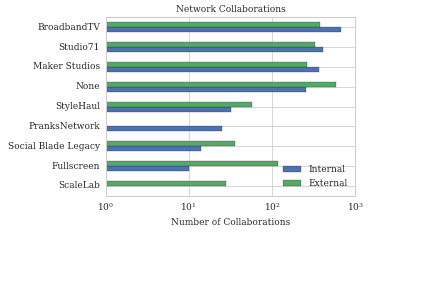

In [143]:
# Show the numbers of collabs in their own network in difference to outside of networks
# (from==to and from!=to)

in_out = []
test = df_network_pairs_collabs.groupby(by='from_network')
for name, group in test:
    #print name, ':'
    in_out.append( (name, group[group.to_network == name]['nof_collabs'].sum(), group[group.to_network != name]['nof_collabs'].sum()) )


df_collabs_in_out = pa.DataFrame(in_out, columns=['network', 'within', 'outreaching'])
df_collabs_in_out_vis = df_collabs_in_out[ (df_collabs_in_out.within+df_collabs_in_out.outreaching > 25)].sort_values(by='within', ascending=True)
ax = df_collabs_in_out_vis.plot(kind='barh')
ax.set_yticklabels(df_collabs_in_out_vis['network'].tolist())
ax.set_xlabel('Number of Collaborations')
ax.set_ylabel('Network')
ax.set_xscale('log')
ax.legend(loc=0, labels=['Internal', 'External'])
plt.title('Network Collaborations')
plt.tight_layout()
save_plot('collab_network_within_out.pdf', ax.get_figure(), 1.5*s_width,  1.5*s_height)

In [145]:
def compute_percentage(x):
    #print x['sum']
    pct = float(x['within'])/float(x['sum']) * 100
    return round(pct, 2)

df_collabs_in_out['sum'] = df_collabs_in_out['within'] + df_collabs_in_out['outreaching']
df_collabs_in_out['within_p'] = df_collabs_in_out.apply(compute_percentage, axis=1)

def compute_percentage(x):
    #print x
    pct = float(x['outreaching'])/float(x['sum']) * 100
    return round(pct, 2)

df_collabs_in_out['outreaching_p'] = df_collabs_in_out.apply(compute_percentage, axis=1)

df_collabs_in_out

,network,within,outreaching,sum,within_p,outreaching_p
0,2btube,0,1,1,0.00,100.00
1,Age of Media,0,2,2,0.00,100.00
2,Alloy,0,5,5,0.00,100.00
3,Arcane,0,1,1,0.00,100.00
4,AwesomenessTV,0,16,16,0.00,100.00
5,Base79,0,1,1,0.00,100.00
6,BentPixels,0,3,3,0.00,100.00
7,BigFrame,0,12,12,0.00,100.00
8,BodyMindZone,1,10,11,9.09,90.91
9,Break,0,1,1,0.00,100.00


In [146]:
df_collabs_in_out[df_collabs_in_out['sum'] > 25].sort_values(by='within')

,network,within,outreaching,sum,within_p,outreaching_p
53,ScaleLab,0,28,28,0.00,100.00
34,Fullscreen,10,118,128,7.81,92.19
55,Social Blade Legacy,14,36,50,28.00,72.00
51,PranksNetwork,25,1,26,96.15,3.85
59,StyleHaul,32,58,90,35.56,64.44
48,None,258,592,850,30.35,69.65
42,Maker Studios,364,266,630,57.78,42.22
58,Studio71,411,328,739,55.62,44.38
10,BroadbandTV,664,373,1037,64.03,35.97


<IPython.core.display.Javascript object>


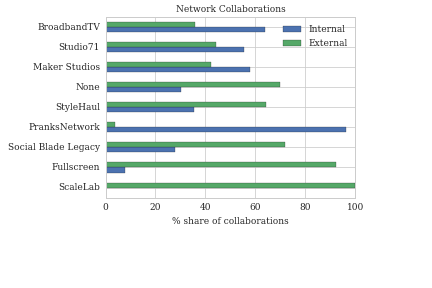

In [149]:
# Show the numbers of collabs in their own network in difference to outside of networks
# (from==to and from!=to)
import matplotlib.ticker as mtick


df_collabs_in_out_vis = df_collabs_in_out[df_collabs_in_out['sum'] > 25].sort_values(by='within', ascending=True)
df_collabs_in_out_vis = df_collabs_in_out_vis[['network', 'within_p', 'outreaching_p']]
ax = df_collabs_in_out_vis.plot(kind='barh')
ax.set_yticklabels(df_collabs_in_out_vis['network'].tolist())
ax.set_xlabel('% share of collaborations')
ax.set_ylabel('Network')
ax.legend(loc=0, labels=['Internal', 'External'])
plt.title('Network Collaborations')
plt.tight_layout()
save_plot('collab_network_within_out_perc.pdf', ax.get_figure(), 1.5*s_width,  1.5*s_height)



In [77]:
df_collabs_in_out.sort_values(by=['within', 'outreaching'], ascending=False).to_csv(DIR+r'/df_network_collabs_within_out.txt', sep=str('\t'), encoding='utf-8')

number of collabs: 1728
Empty DataFrame
Columns: [cluster, from, from_category, from_cluster, from_network, from_popularity, from_topic, to, to_category, to_cluster, to_network, to_popularity, to_topic, videos, weight]
Index: []
Empty DataFrame
Columns: [cluster, from, from_category, from_cluster, from_network, from_popularity, from_topic, to, to_category, to_cluster, to_network, to_popularity, to_topic, videos, weight]
Index: []
15 [u'Cars & Vehicles' u'Comedy' u'Education' u'Entertainment'
 u'Film & Animation' u'Gaming' u'How-to & Style' u'Music'
 u'News & Politics' u'Non-profits & Activism' u'People & Blogs'
 u'Pets & Animals' u'Science & Technology' u'Sports' u'Travel & Events']
15 [u'Cars & Vehicles' u'Comedy' u'Education' u'Entertainment'
 u'Film & Animation' u'Gaming' u'How-to & Style' u'Music'
 u'News & Politics' u'Non-profits & Activism' u'People & Blogs'
 u'Pets & Animals' u'Science & Technology' u'Sports' u'Travel & Events']
(15, 15)


<IPython.core.display.Javascript object>


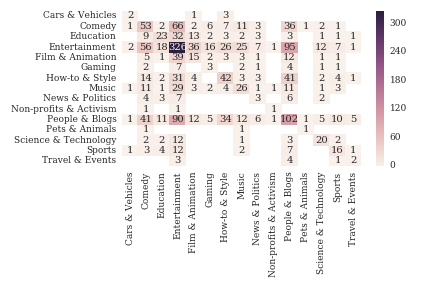

<IPython.core.display.Javascript object>


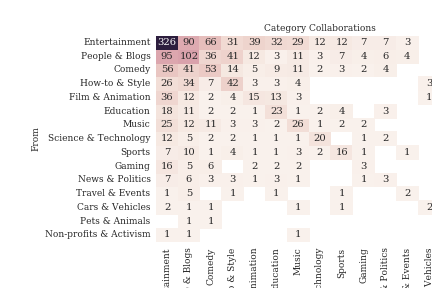

<IPython.core.display.Javascript object>


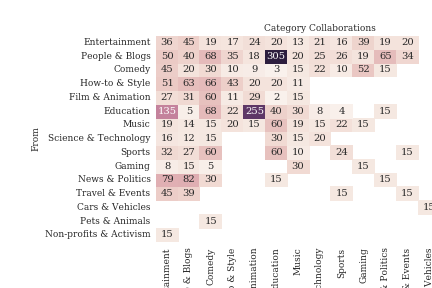

In [61]:
# Collabs between channel categories

print 'number of collabs:', len(df_graph_filtered)

print df_graph_filtered[df_graph_filtered.from_category.isnull()]
print df_graph_filtered[df_graph_filtered.to_category.isnull()]

Xuniques, X = np.unique(df_graph_filtered['from_category'], return_inverse=True)
Yuniques, Y = np.unique(df_graph_filtered['to_category'], return_inverse=True)

#cats = df_graph[['to_category', 'from_category']]
cats = pa.DataFrame([X, Y]).T
#print cats
print len(Xuniques), Xuniques #, X
print len(Yuniques), Yuniques #, Y

arrc = np.zeros((len(Yuniques), len(Xuniques)))

print arrc.shape

sum = 0.0

for row in cats.iterrows():
    #print row[0], row[1][0], row[1][1]
    arrc[row[1][0], row[1][1]] += 1
    sum += 1

arr_p = arrc / sum * 100
    
fig = plt.figure()
ax = sns.heatmap(arrc, annot=True, yticklabels=Yuniques, xticklabels=Xuniques, fmt='g', mask=arrc <= 0.0)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
#ax.invert_yaxis()
fig.tight_layout()
#fig.subplots_adjust(bottom=0.2)



cat_test = []
for name, group in df_graph_filtered.groupby(['from_category', 'to_category']):
    #print group.index
    cat_test.append((name[0], name[1], len(group)))

df_cat = pa.DataFrame(cat_test, columns=['from_category','to_category', 'nof_collabs'])
df_cat = df_cat.set_index(['from_category', 'to_category'])
df_cat = df_cat.sort_values(by='nof_collabs', ascending=False)

fig.tight_layout()
#fig.subplots_adjust(bottom=0.2)

index_test = df_cat.index.values
index_test1, index_test2 = zip(*index_test)

index_test1 = unique(index_test1)
index_test2 = unique(index_test2)

test = df_cat.unstack(0)
test = test.reindex(index_test1)

new_test = []
for lvl in index_test1:
    new_test.append(test[('nof_collabs', lvl)])
new_test = pa.DataFrame(new_test).T


new_test_2 = new_test.copy()

for i, row in new_test_2.iterrows():
    for j, item in row.iteritems():
        v = 0
        for l in df_graph_filtered[(df_graph_filtered.from_category==i) & (df_graph_filtered.to_category==j[1])]['videos']:
            v += len(l)
        #print i, j, item, v
        if item and v:
            new_test_2.loc[(i, j)] = v/item #item/v
        else:
            new_test_2.loc[(i, j)] = np.nan


fig = plt.figure()
ax = sns.heatmap(new_test, annot=True, yticklabels=index_test1, xticklabels=index_test1, fmt='g', cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
plt.title('Category Collaborations')
plt.tight_layout()
save_plot('collab_category_heatmap.pdf', fig, x_width, 1.5*x_height)


fig = plt.figure()
ax = sns.heatmap(new_test_2, annot=True, yticklabels=index_test1, xticklabels=index_test1, fmt='.0f', cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
plt.title('Category Collaborations')
save_plot('collab_category_heatmap_normalized.pdf', fig, x_width, 1.5*x_height)

number of collabs: 1728
Empty DataFrame
Columns: [cluster, from, from_category, from_cluster, from_network, from_popularity, from_topic, to, to_category, to_cluster, to_network, to_popularity, to_topic, videos, weight]
Index: []
Empty DataFrame
Columns: [cluster, from, from_category, from_cluster, from_network, from_popularity, from_topic, to, to_category, to_cluster, to_network, to_popularity, to_topic, videos, weight]
Index: []
15 [u'Cars & Vehicles' u'Comedy' u'Education' u'Entertainment'
 u'Film & Animation' u'Gaming' u'How-to & Style' u'Music'
 u'News & Politics' u'Non-profits & Activism' u'People & Blogs'
 u'Pets & Animals' u'Science & Technology' u'Sports' u'Travel & Events']
15 [u'Cars & Vehicles' u'Comedy' u'Education' u'Entertainment'
 u'Film & Animation' u'Gaming' u'How-to & Style' u'Music'
 u'News & Politics' u'Non-profits & Activism' u'People & Blogs'
 u'Pets & Animals' u'Science & Technology' u'Sports' u'Travel & Events']
(15, 15)
1728.0
<U22


<IPython.core.display.Javascript object>


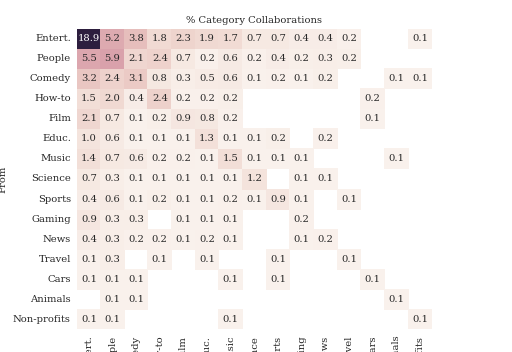

In [219]:
# Collabs between channel categories

print 'number of collabs:', len(df_graph_filtered)

print df_graph_filtered[df_graph_filtered.from_category.isnull()]
print df_graph_filtered[df_graph_filtered.to_category.isnull()]

Xuniques, X = np.unique(df_graph_filtered['from_category'], return_inverse=True)
Yuniques, Y = np.unique(df_graph_filtered['to_category'], return_inverse=True)

#cats = df_graph[['to_category', 'from_category']]
cats = pa.DataFrame([X, Y]).T
#print cats
print len(Xuniques), Xuniques #, X
print len(Yuniques), Yuniques #, Y

arrc = np.zeros((len(Yuniques), len(Xuniques)))

print arrc.shape

sum = 0.0

for row in cats.iterrows():
    #print row[0], row[1][0], row[1][1]
    arrc[row[1][0], row[1][1]] += 1
    sum += 1

arrc = arrc / sum * 100
    
print sum

sum = 0.0

def shorter(x):
    try:
        return {'Film & Animation': 'Film',
               'Cars & Vehicles': 'Cars',
               'Pets & Animals': 'Animals',
               'Travel & Events': 'Travel',
               'People & Blogs': 'People',
               'Entertainment': 'Entert.',
               'Education': 'Educ.',
               'News & Politics': 'News',
               'How-to & Style': 'How-to',
               'Science & Technology': 'Science',
               'Non-profits & Activism': 'Non-profits'}[x]
    except:
        return x

cat_test = []
for name, group in df_graph_filtered.groupby(['from_category', 'to_category']):
    #print group.index
    cat_test.append((name[0], name[1], len(group)))
    sum += len(group)

df_cat = pa.DataFrame(cat_test, columns=['from_category','to_category', 'nof_collabs'])
df_cat['nof_collabs'] = df_cat['nof_collabs'].apply(lambda x: x / sum * 100.0)
df_cat = df_cat.set_index(['from_category', 'to_category'])
df_cat = df_cat.sort_values(by='nof_collabs', ascending=False)

fig.tight_layout()
#fig.subplots_adjust(bottom=0.2)

index_test = df_cat.index.values
index_test1, index_test2 = zip(*index_test)

index_test1 = unique(index_test1)
index_test2 = unique(index_test2)

print index_test1.dtype

test = df_cat.unstack(0)
test = test.reindex(index_test1)

new_test = []
for lvl in index_test1:
    new_test.append(test[('nof_collabs', lvl)])
new_test = pa.DataFrame(new_test).T



func = np.vectorize(shorter)
index_test1 = func(index_test1)

fig = plt.figure()
ax = sns.heatmap(new_test, annot=True, yticklabels=index_test1, xticklabels=index_test1, fmt='.1f', cbar=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
plt.title('% Category Collaborations')
plt.tight_layout()
save_plot('collab_category_heatmap_perc_s.pdf', fig, 1.6*s_width, 2.6*s_height)


<IPython.core.display.Javascript object>


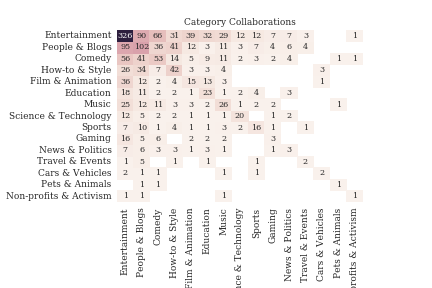

<IPython.core.display.Javascript object>


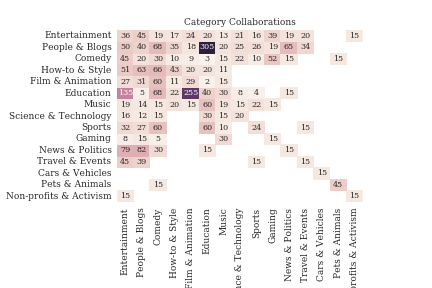

In [63]:
fig = plt.figure()
ax = sns.heatmap(new_test, annot=True, yticklabels=index_test1, xticklabels=index_test1, fmt='g', cbar=False, annot_kws={"size": 8})
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
plt.title('Category Collaborations')
plt.tight_layout()
save_plot('collab_category_heatmap_s.pdf', fig, 1.5*s_width, 2.5*s_height)


fig = plt.figure()
ax = sns.heatmap(new_test_2, annot=True, yticklabels=index_test1, xticklabels=index_test1, fmt='.0f', cbar=False, annot_kws={"size": 8})
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_xlabel('To')
ax.set_ylabel('From')
plt.title('Category Collaborations')
save_plot('collab_category_heatmap_normalized_s.pdf', fig, 1.5*s_width, 2.5*s_height)

In [64]:
# make list for gaming collabs

filtered = df_graph_filtered[df_graph_filtered['to_category']=='Gaming']


def get_name(id):
    with db._session_scope(False) as session:
        return session.query(Channel.title).filter(Channel.id == id).first()[0]
    
filtered['from_channel'] = filtered['from'].apply(get_name)
filtered['to_channel'] = filtered['to'].apply(get_name)

filtered[['from_channel', 'from_category', 'from_cluster', 'from_popularity', 'to_channel', 'to_category', 'to_cluster', 'to_popularity', 'videos', 'weight']].to_csv(DIR+r'/gaming_collabs.csv', sep=str('\t'), encoding='utf-8')

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [49]:
# prefiltered cluster analyse atm not interesting as proba and persistence of hdbscan is not very diverse
# because we only used the first 20 cluster instead of 100

#df_collabs_prefiltered = pa.read_csv(DIR+r'/hdb_collab_prefiltered_cluster.txt', sep=str('\t'), encoding='utf-8')
#df_collabs_prefiltered.head()

pers = np.load(DIR+'/hdbscan_pers.npy')
proba = np.load(DIR+'/hdbscan_proba.npy')

IOError: [Errno 2] No such file or directory: '../../data/data_evaluation_3MONTHS/hdbscan_pers.npy'

<IPython.core.display.Javascript object>


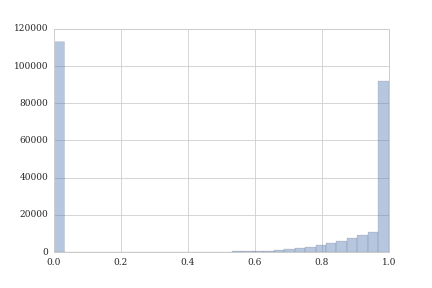

<IPython.core.display.Javascript object>


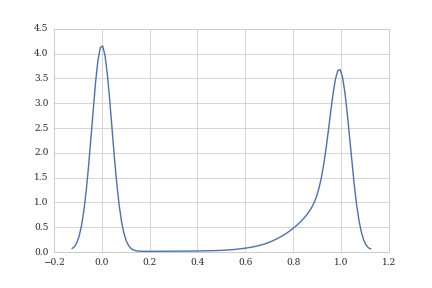

<IPython.core.display.Javascript object>


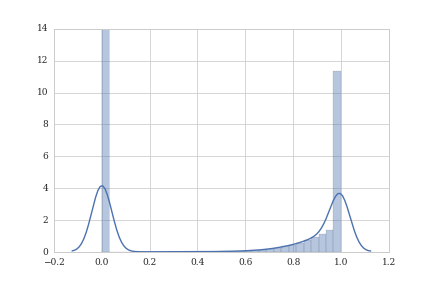

In [55]:
fig = plt.figure()
ax1 = sns.distplot(proba, kde=False)

fig = plt.figure()
ax2 = sns.distplot(proba, hist=False)

fig = plt.figure()
ax3 = sns.distplot(proba)


<IPython.core.display.Javascript object>


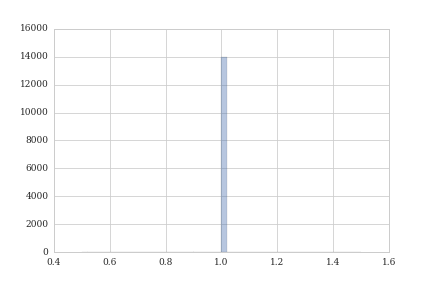

<IPython.core.display.Javascript object>


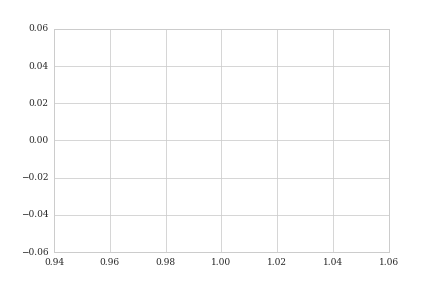

/home/mlode/intel/intelpython27/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/mlode/intel/intelpython27/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


<IPython.core.display.Javascript object>


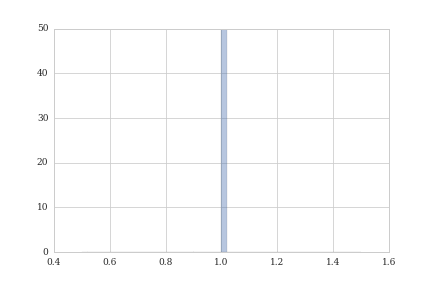

In [56]:
fig = plt.figure()
ax1 = sns.distplot(pers, kde=False)

fig = plt.figure()
ax2 = sns.distplot(pers, hist=False)

fig = plt.figure()
ax3 = sns.distplot(pers)


<IPython.core.display.Javascript object>


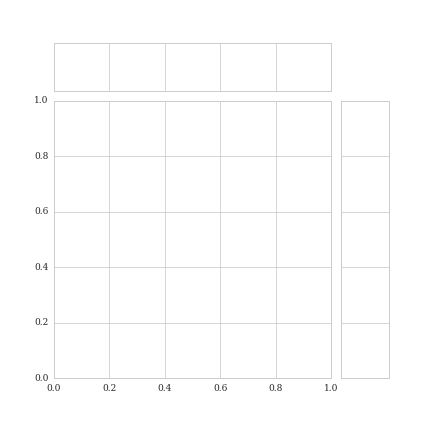

ValueError: operands could not be broadcast together with shapes (14010,) (258726,) 

In [57]:
sns.jointplot(x=pers, y=proba)